# Memory Augmented Agents: Filesystems + Oracle AI Database for Context and Memory Engineering In AI Agents (LangChain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oracle-devrel/oracle-ai-developer-hub/blob/main/notebooks/fs_vs_dbs.ipynb)

-----

# Filesystem vs Database: Agent Memory Architectures

This notebook explores different approaches to **agent memory** using LangChain and compares their performance.

**What's covered:**

- **Part 1: FSAgent** - Filesystem-based memory using markdown files. Fast local I/O, human-readable, git-friendly.

- **Part 2: MemAgent** - Database-backed memory using Oracle SQL tables and vector embeddings. ACID guarantees, semantic search, production-ready.

- **Part 3: Benchmarking** - End-to-end agent tests measuring latency and LLM-as-judge evaluation.

- **Part 4: ACID Transactions & Concurrency** - Demonstrates database ACID guarantees vs filesystem concurrency limitations.

**Requirements:** Python 3.10+, Oracle Database, OpenAI API key

> **Tip:** Run the Docker section first if you don't have Oracle AI Database running locally.

# Use Case and Background

-----

### Use Case

We're building a **Research Agent** that can fetch papers from arXiv, store them in memory, and answer questions about their content. The focus is on comparing **two memory architectures**:

- **Filesystem memory** - Papers stored as markdown files, searched via keyword matching
- **Database memory** - Papers chunked and embedded in a vector store for semantic search

The agent demonstrates how memory architecture affects both **retrieval speed** and **answer quality**. We then combine both approaches into a **hybrid system** that writes to the filesystem for speed and queries the database for intelligence.

This is a practical exploration of the trade-offs between simple file-based storage and production-grade database systems for agent memory.

### Workload Patterns (Filesystem vs Database)

| Pattern | FSAgent (Filesystem) | MemAgent (Database) | MemFSAgent (Hybrid) |
|---------|---------------------|---------------------|---------------------|
| **Conversation history** | Append to markdown files per thread | SQL table with thread_id, role, content | Write to FS first, background sync to DB |
| **Knowledge storage** | Full papers as `.md` files | Chunked + embedded in vector store | Store in both, query from DB |
| **Search/retrieval** | Keyword matching (grep-style) | Semantic similarity search | DB-first with FS fallback |
| **Write latency** | Fast (local I/O) | Slower (DB + embedding) | Fast (FS immediate) |
| **Read quality** | Limited (exact match) | Better (understands meaning) | Best of both |
| **Persistence** | File-based | ACID guarantees | Redundant (both) |
| **Human readable** | Yes (markdown) | No (DB rows) | Yes (FS copy) |

### Evaluation Metrics

We benchmark each agent using two metrics:

| Metric | Description |
|--------|-------------|
| **Latency** | Time to complete each agent query (paper retrieval, Q&A) |
| **LLM-as-Judge** | An LLM scores each response for relevance and accuracy on a 0-100% scale |

These metrics let us compare both **speed** (latency) and **quality** (LLM judgment) across filesystem and database approaches.

### Loading Libaries and Setting Environment Variables

### Dependencies

| Library | Purpose |
|---------|---------|
| `langchain` | Core framework for building LLM agents and chains |
| `langchain-community` | Community integrations (ArxivLoader, etc.) |
| `langchain_openai` | OpenAI LLM and embedding models |
| `langchain_oracledb` | Oracle vector store integration |
| `oracledb` | Python driver for Oracle Database |
| `arxiv` | Fetching papers from arXiv API |
| `pymupdf` | PDF parsing for paper content extraction |
| `sentence-transformers` | Local embedding models (optional fallback) |
| `matplotlib` | Visualization for benchmark charts |

In [1]:
! pip install -qU langchain langchain-community arxiv langchain_oracledb pymupdf langchain_openai oracledb sentence-transformers matplotlib

### API Keys Required

| Key | Required | Where to Get It |
|-----|----------|-----------------|
| `OPENAI_API_KEY` | Yes | [OpenAI Platform](https://platform.openai.com/api-keys) - Used for embeddings and LLM calls |
| `LANGSMITH_API_KEY` | Optional | [LangSmith](https://smith.langchain.com/) - For tracing and debugging agent runs |

**Setup options:**
1. Set environment variables in your shell before running the notebook
2. Use the `set_env_variable()` helper below to enter keys securely
3. Create a `.env` file and load it with `python-dotenv`

In [2]:
import os
import getpass

def set_env_variable(key: str) -> str:
    """
    Prompt for a value (hidden input) and set it as an environment variable.
    Returns the value that was set.
    """
    value = getpass.getpass(f"Enter value for {key}: ")
    os.environ[key] = value
    return value

In [3]:
set_env_variable("OPENAI_API_KEY")
set_env_variable("LANGSMITH_TRACING")
set_env_variable("LANGSMITH_ENDPOINT")
set_env_variable("LANGSMITH_API_KEY")


''

# Part 1: FSAgent (Filesystem backed Agent)

----

## What You Will Learn

This section demonstrates how to build a **filesystem-backed research agent** that uses local markdown files as its memory system. By the end of Part 1, you will understand:

### Architecture Overview

The FSAgent organizes memory into two directories:
- **`semantic/`** - Long-term knowledge storage (research papers, facts)
- **`episodic/`** - Session-based memory (conversation transcripts, summaries)

### Step-by-Step Implementation

**1.1 ArXiv Search Tool**
- Configure the `ArxivRetriever` from LangChain to search academic papers
- Build `arxiv_search_candidates()` to return structured paper metadata (ID, title, authors, abstract)
- Understand how to limit results and format output for LLM consumption

**1.2 Paper Fetching and Storage**
- Implement `fetch_and_save_paper()` to download PDFs and convert to text
- Save papers directly to `semantic/knowledge_base/<arxiv_id>.md`
- Learn the pattern of bypassing LLM context to prevent truncation of large documents

**1.3 File Reading Tools (Progressive Disclosure)**
- `read_file()` - Full file retrieval for small documents
- `tail_file()` - Read last N lines to check recent content first
- `read_file_range()` - Targeted line range extraction
- `grep_files()` - Pattern-based search across the knowledge base
- `list_papers()` - Directory listing for available papers

**1.4 Episodic Memory Management**
- `conversation_to_file()` - Append chat turns to `episodic/transcripts/<run_id>.md`
- `summarise_conversation_to_file()` - Generate and save conversation summaries
- Understand the separation between raw transcripts and compressed summaries

**1.5 Context Window Monitoring**
- `monitor_context_window()` - Track token usage in real-time
- Implement threshold-based warnings before hitting context limits
- Learn how to trigger summarization when approaching capacity

**1.6 Agent Assembly**
- Combine all tools into `FS_TOOLS` list
- Configure the LangChain agent with system prompts
- Build the interactive chat loop with memory persistence

### Key Patterns Demonstrated

| Pattern | Description |
|---------|-------------|
| **Just-in-Time Retrieval** | Load files only when needed, not upfront |
| **Progressive Disclosure** | Use `tail_file` before `read_file` to minimize token usage |
| **Bypass LLM for Large Data** | Save papers directly to disk without passing through context |
| **Structured File Layout** | Consistent directory structure for predictable retrieval |
| **Token-Aware Operation** | Monitor and manage context window proactively |

### FSAgent tools

| Tool | What it does | Output |
|---|---|---|
| **arxiv_search_candidates(query, k=5)** | Searches arXiv and returns a JSON list of candidate papers with IDs, titles, authors, and abstracts. | JSON string of paper candidates |
| **fetch_and_save_paper(arxiv_id)** | Fetches full paper text (PDF to text) and saves directly to `semantic/knowledge_base/<id>.md`. Avoids routing full content through LLM. | File path |
| **read_file(path)** | Reads a file from disk and returns its contents in full. Use to reload stored papers or transcripts just-in-time. | Full file contents |
| **tail_file(path, n_lines=80)** | Reads the last N lines of a file. Use first when a file is large. | Last N lines of file |
| **read_file_range(path, start_line, end_line)** | Reads a specific line range from a file (inclusive start, exclusive end). Use after tail_file to expand around relevant regions. | Selected line range |
| **grep_files(pattern, root_dir, file_glob)** | Grep-like search across local files to find relevant passages by keyword/pattern. | Matches with file path and context |
| **list_papers()** | Lists all locally saved paper files in `semantic/knowledge_base/`. | List of filenames |
| **conversation_to_file(run_id, messages)** | Appends conversation entries to a single transcript file per run in `episodic/transcripts/`. | File path |
| **summarise_conversation_to_file(run_id, messages)** | Saves full transcript to episodic memory, then writes a compact summary to `episodic/summaries/`. | Dict with transcript and summary paths |
| **monitor_context_window(messages)** | Estimates current context usage (tokens used, remaining, percentage). | Dict with token stats |

## 1.1 Create Arxiv search tool for papers

The first step in building our research agent is enabling it to discover relevant academic papers. We use LangChain's `ArxivRetriever` to query the arXiv API, then wrap it in a custom tool that returns structured JSON with paper metadata. This approach gives the agent a curated list of candidates without overwhelming the context window with full paper content.

In [4]:
from langchain_community.retrievers import ArxivRetriever

arxiv_retriever = ArxivRetriever(
    load_max_docs=8,
    get_full_documents=False,
    doc_content_chars_max=4000
)

In [5]:
docs = arxiv_retriever.invoke("agent memory long-term evaluation benchmark")
print(len(docs))
print(docs[0].metadata)  # arxiv metadata (id, title, authors, etc.)
print(docs[0].page_content[:800])

/opt/homebrew/Caskroom/miniconda/base/envs/filesystemsvsdbs/lib/python3.12/site-packages/langsmith/client.py:498: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019c0bb2-6312-7850-bc6a-2b178b1f9db0,id=019c0bb2-6312-7850-bc6a-2b178b1f9db0


3
{'Entry ID': 'http://arxiv.org/abs/2210.13383v1', 'Published': datetime.date(2022, 10, 24), 'Title': 'Evaluating Long-Term Memory in 3D Mazes', 'Authors': 'Jurgis Pasukonis, Timothy Lillicrap, Danijar Hafner'}
Intelligent agents need to remember salient information to reason in partially-observed environments. For example, agents with a first-person view should remember the positions of relevant objects even if they go out of view. Similarly, to effectively navigate through rooms agents need to remember the floor plan of how rooms are connected. However, most benchmark tasks in reinforcement learning do not test long-term memory in agents, slowing down progress in this important research direction. In this paper, we introduce the Memory Maze, a 3D domain of randomized mazes specifically designed for evaluating long-term memory in agents. Unlike existing benchmarks, Memory Maze measures long-term memory separate from confounding agent abilities and requires the agent to localize itsel

> 💡 **Key Takeaways**
> - Return metadata (ID, title, abstract) instead of full content to preserve context space
> - Use structured JSON output so the agent can programmatically select papers
> - The retriever handles API rate limiting and pagination automatically

## 1.2 Paper Fetching and Storage

Once the agent identifies papers of interest, it needs to retrieve and persist the full content. The `fetch_and_save_paper` tool downloads the PDF, converts it to plain text, and writes it directly to the filesystem at `semantic/knowledge_base/<arxiv_id>.md`. This bypasses the LLM entirely, preventing truncation of large documents and keeping the context window free for reasoning.

In [6]:
import json
from urllib.parse import urlparse
from langchain_core.tools import tool

def _arxiv_id_from_entry_id(entry_id: str) -> str:
    """
    Convert 'http://arxiv.org/abs/2310.08560v2' -> '2310.08560v2'
    """
    if not entry_id:
        return ""
    path = urlparse(entry_id).path  # e.g. '/abs/2310.08560v2'
    return path.split("/abs/")[-1].strip("/")

@tool
def arxiv_search_candidates(query: str, k: int = 5) -> str:
    """
    Search arXiv and return a JSON list of candidate papers with IDs + metadata.

    Output schema (JSON string):
    [
      {
        "arxiv_id": "2310.08560v2",
        "entry_id": "http://arxiv.org/abs/2310.08560v2",
        "title": "...",
        "authors": "...",
        "published": "2024-02-12",
        "abstract": "..."
      },
      ...
    ]
    """
    docs = arxiv_retriever.invoke(query)  # uses your existing ArxivRetriever
    candidates = []
    for d in (docs or [])[:k]:
        meta = d.metadata or {}
        entry_id = meta.get("Entry ID", "")
        candidates.append({
            "arxiv_id": _arxiv_id_from_entry_id(entry_id),
            "entry_id": entry_id,
            "title": meta.get("Title", ""),
            "authors": meta.get("Authors", ""),
            "published": str(meta.get("Published", "")),
            "abstract": (d.page_content or "")[:2500],  # keep lightweight
        })
    return json.dumps(candidates, ensure_ascii=False, indent=2)


In [7]:
from pathlib import Path
from langchain_community.document_loaders import ArxivLoader

@tool
def fetch_and_save_paper(arxiv_id: str, semantic_dir: str = "semantic") -> str:
    """
    Fetch full paper text (PDF->text) and save directly to semantic/knowledge_base/<id>.md.
    Avoids routing full content through the LLM, preventing truncation.
    """
    kb_dir = Path(semantic_dir) / "knowledge_base"
    kb_dir.mkdir(parents=True, exist_ok=True)

    loader = ArxivLoader(
        query=arxiv_id,
        load_max_docs=1,
        doc_content_chars_max=None,  # no truncation
    )
    docs = loader.load()
    if not docs:
        return f"No documents found for arXiv id: {arxiv_id}"

    doc = docs[0]
    title = (
        doc.metadata.get("Title")
        or doc.metadata.get("title")
        or f"arXiv {arxiv_id}"
    )
    content = doc.page_content

    path = kb_dir / f"{arxiv_id}.md"
    path.write_text(f"# {title}\n\n{content}", encoding="utf-8")
    return str(path)

/opt/homebrew/Caskroom/miniconda/base/envs/filesystemsvsdbs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019c0bb2-6312-7850-bc6a-2b178b1f9db0,id=019c0bb2-6312-7850-bc6a-2b178b1f9db0


> 💡 **Key Takeaways**
> - Write large documents directly to disk—never route them through the LLM context
> - Use consistent file naming (`<arxiv_id>.md`) for predictable retrieval later
> - PDF-to-text conversion loses formatting but preserves the content that matters

## 1.3 File Reading Tools (Progressive Disclosure)

Reading entire files into the context window is wasteful when you only need a specific section. This section implements a suite of file reading tools that support progressive disclosure: start with `tail_file` to peek at recent content, use `grep_files` to locate specific passages, then retrieve targeted sections with `read_file_range`. Only fall back to `read_file` when you genuinely need the complete document.

In [8]:
@tool
def read_file(path: str) -> str:
    """
    Read a file from disk and return its contents in full.
    Use this to reload stored papers or conversation transcripts just-in-time.
    """
    p = Path(path)
    if not p.exists():
        return f"File not found: {path}"
    return p.read_text(encoding="utf-8")

In [9]:
@tool
def tail_file(path: str, n_lines: int = 80) -> str:
    """
    Read the last N lines of a file.

    Use this first when a file is large. If you need more context,
    call read_file_range (or increase n_lines).
    """
    p = Path(path)
    if not p.exists():
        return f"File not found: {path}"
    lines = p.read_text(encoding="utf-8").splitlines()
    return "\n".join(lines[-max(1, n_lines):])

In [10]:
@tool
def read_file_range(path: str, start_line: int, end_line: int) -> str:
    """
    Read a specific line range from a file (inclusive start, exclusive end).

    Use after tail_file to expand around relevant regions without loading
    the entire file into the context window.
    """
    p = Path(path)
    if not p.exists():
        return f"File not found: {path}"
    lines = p.read_text(encoding="utf-8").splitlines()
    start = max(0, start_line)
    end = min(len(lines), end_line)
    if start >= end:
        return f"Empty range: {start_line}:{end_line} (file has {len(lines)} lines)"
    return "\n".join(lines[start:end])

In [11]:
import re

@tool
def grep_files(
    pattern: str,
    root_dir: str = "semantic",
    file_glob: str = "**/*.md",
    max_matches: int = 200,
    ignore_case: bool = True,
) -> str:
    """
    Search files under a directory for a pattern (grep-like).

    Returns matching lines with file path + line number so the agent can
    jump to the right region using read_file_range.

    Args:
        pattern: Text or regex pattern to search for.
        root_dir: Directory to search under (default: "semantic").
        file_glob: Which files to include (default: markdown files recursively).
        max_matches: Safety cap on total returned matches.
        ignore_case: Case-insensitive matching (default True).

    Returns:
        A compact report of matches: <path>:<line_no>: <line>
    """
    root = Path(root_dir)
    if not root.exists():
        return f"Directory not found: {root_dir}"

    flags = re.IGNORECASE if ignore_case else 0
    try:
        rx = re.compile(pattern, flags)
    except re.error as e:
        return f"Invalid regex pattern: {e}"

    matches = []
    for fp in root.glob(file_glob):
        if not fp.is_file():
            continue
        try:
            lines = fp.read_text(encoding="utf-8", errors="ignore").splitlines()
        except Exception as e:
            continue

        for i, line in enumerate(lines, start=1):
            if rx.search(line):
                matches.append(f"{fp.as_posix()}:{i}: {line.strip()}")
                if len(matches) >= max_matches:
                    return "\n".join(matches) + "\n\n[TRUNCATED: max_matches reached]"

    if not matches:
        return "No matches found."
    return "\n".join(matches)


> 💡 **Key Takeaways**
> - Always try `tail_file` or `grep_files` before loading entire files
> - Line-range retrieval (`read_file_range`) minimizes token usage for targeted lookups
> - Pattern-based search scales better than loading all files into context

## 1.4 Episodic Memory Management

While semantic memory stores facts and knowledge, episodic memory captures the agent's experiences—its conversation history. This section implements tools to persist chat transcripts to `episodic/transcripts/` and generate compressed summaries in `episodic/summaries/`. The LLM creates these summaries, extracting key decisions and insights while discarding redundant back-and-forth.

In [12]:
@tool
def list_papers(semantic_dir: str = "semantic") -> list[str]:
    """
    List locally saved paper files in the semantic knowledge base directory.

    Folder layout:
      semantic/knowledge_base/*.md

    Args:
        semantic_dir: Root directory for semantic memory (default: "semantic").

    Returns:
        A sorted list of file paths (e.g., ["semantic/knowledge_base/2401.01234.md", ...]).
        Returns an empty list if the directory does not exist or contains no .md files.
    """
    kb_dir = Path(semantic_dir) / "knowledge_base"
    if not kb_dir.exists():
        return []
    return sorted(str(f) for f in kb_dir.glob("*.md"))


In [13]:
from datetime import datetime, timezone
from typing import List, Dict, Any


def _ts_utc() -> str:
    return datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")

def _format_blocks(messages: List[Dict[str, str]]) -> str:
    """Format messages as appendable markdown blocks with timestamps."""
    blocks = []
    for m in messages:
        role = (m.get("role") or "unknown").lower()
        if role in {"tool", "function"}:
            continue  # remove tool calls/tool outputs from conversation.md
        content = m.get("content", "")
        ts = m.get("ts") or _ts_utc()
        blocks.append(f"### {ts} — {role.upper()}\n\n{content}\n")
    return "\n".join(blocks) + ("\n" if blocks else "")

def _messages_to_markdown(messages: List[Dict[str, str]]) -> str:
    lines = []
    for m in messages:
        role = m.get("role", "unknown").upper()
        content = m.get("content", "")
        lines.append(f"## {role}\n\n{content}\n")
    return "\n".join(lines)


@tool
def conversation_to_file(
    run_id: str,
    messages: List[Dict[str, str]],
    episodic_dir: str = "episodic",
) -> str:
    """
    Append conversation entries to a single transcript file per run:
      episodic/conversations/<run_id>.md

    Tool messages are ignored (tool output is logged separately via EpisodicToolLogger).
    Each entry is timestamped.
    """
    conversations_dir = Path(episodic_dir) / "conversations"
    conversations_dir.mkdir(parents=True, exist_ok=True)

    path = conversations_dir / f"{run_id}.md"

    if not path.exists():
        header = f"# Conversation Transcript\n\nRun: `{run_id}`\nCreated: {_ts_utc()}\n\n---\n\n"
        path.write_text(header, encoding="utf-8")

    # Append new blocks
    path.write_text(path.read_text(encoding="utf-8") + _format_blocks(messages), encoding="utf-8")
    return str(path)

In [14]:
from langchain_openai import ChatOpenAI


@tool
def summarise_conversation_to_file(
    run_id: str,
    messages: List[Dict[str, str]],
    episodic_dir: str = "episodic",
) -> Dict[str, str]:
    """
    Save the full transcript to episodic memory, then write a compact summary to episodic/summaries/.

    Returns:
      {
        "transcript_path": "...",
        "summary_path": "...",
        "summary": "..."
      }
    """
    transcript_path = conversation_to_file.invoke(
        {"run_id": run_id, "messages": messages, "episodic_dir": episodic_dir}
    )

    model = ChatOpenAI(model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"), temperature=0)

    prompt = (
        "Summarise this conversation for future continuity.\n\n"
        "Requirements:\n"
        "- Capture key facts, decisions, and constraints.\n"
        "- Capture open questions / next steps.\n"
        "- Keep it concise (aim ~200-400 words).\n"
        "- Do NOT invent details.\n\n"
        f"Transcript file reference: {transcript_path}\n\n"
        "Conversation:\n"
        + _messages_to_markdown(messages)
    )
    summary_text = model.invoke(prompt).content

    summaries_dir = Path(episodic_dir) / "summaries"
    summaries_dir.mkdir(parents=True, exist_ok=True)

    ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
    summary_path = summaries_dir / f"{run_id}_{ts}_summary.md"
    summary_path.write_text(
        f"# Conversation Summary\n\nTranscript: {transcript_path}\n\n{summary_text}",
        encoding="utf-8",
    )

    return {
        "transcript_path": transcript_path,
        "summary_path": str(summary_path),
        "summary": summary_text,
    }

> 💡 **Key Takeaways**
> - Separate raw transcripts from summaries—keep both for different use cases
> - LLM-generated summaries capture intent and decisions, not just text compression
> - Episodic memory enables multi-session continuity without replaying full history

## 1.5 Context Window Monitoring

LLMs have finite context windows, and exceeding them causes silent truncation or errors. The `monitor_context_window` tool uses tiktoken to count tokens in the current conversation and compare against the model's limit. When usage exceeds a configurable threshold, the agent can proactively trigger summarization to compress history before hitting the ceiling.

In [15]:
import tiktoken

def _count_tokens_approx(messages: List[Dict[str, str]]) -> int:
    # Fallback: ~4 chars/token heuristic
    total_chars = sum(len(m.get("content", "")) for m in messages)
    return max(1, total_chars // 4)

def _count_tokens_tiktoken(messages: List[Dict[str, str]], model_name: str) -> int:
    # Best-effort token counting for OpenAI-like chat messages
    try:
        enc = tiktoken.encoding_for_model(model_name)
    except Exception:
        return _count_tokens_approx(messages)

    # Rough chat accounting (good enough for monitoring)
    tokens = 0
    for m in messages:
        tokens += 4  # role/message overhead (approx)
        tokens += len(enc.encode(m.get("content", "")))
    tokens += 2
    return tokens

@tool
def monitor_context_window(
    messages: List[Dict[str, str]],
    model_name: str = "gpt-4o-mini",
    max_context_tokens: int = 128_000,
) -> Dict[str, Any]:
    """
    Estimate current context usage.
    Returns {tokens_used, max_context_tokens, utilization_ratio}.
    """
    tokens_used = _count_tokens_tiktoken(messages, model_name)
    utilization = tokens_used / max_context_tokens
    return {
        "tokens_used": tokens_used,
        "max_context_tokens": max_context_tokens,
        "utilization_ratio": utilization,
    }

> 💡 **Key Takeaways**
> - Monitor tokens proactively—don't wait for errors or silent truncation
> - Set thresholds (e.g., 80%) to trigger summarization before hitting limits
> - Token counting is cheap; context overflow recovery is expensive

## 1.6 Agent Assembly

With all tools defined, we assemble the complete FSAgent. This involves registering tools in the `FS_TOOLS` list, configuring the LangChain agent with a system prompt that explains the memory architecture, and building the interactive chat loop. The loop persists each turn to the filesystem, monitors context usage, and maintains conversation continuity across sessions.

In [16]:
FS_TOOLS = [
    arxiv_search_candidates, # search arXiv for relevant research papers
    fetch_and_save_paper, # fetch full paper text (PDF->text) and save directly to semantic/knowledge_base/<id>.md
    read_file, # read a file from disk and return its contents in full
    tail_file, # read the last N lines of a file
    read_file_range, # read a specific line range from a file (inclusive start, exclusive end)
    conversation_to_file, # append conversation entries to a single transcript file per run
    summarise_conversation_to_file, # save the full transcript to episodic memory, then write a compact summary to episodic/summaries/.
    monitor_context_window, # estimate current context usage
    list_papers, # list locally saved paper files in the semantic knowledge base directory
    grep_files
]

In [17]:
from langchain.agents import create_agent

fs_agent = create_agent(
    model=f"openai:{os.getenv('OPENAI_MODEL', 'gpt-4o-mini')}",
    tools=FS_TOOLS,
    system_prompt=(
        "You are a conversational research ingestion agent.\n\n"
        "Core behavior:\n"
        "- When asked to find a paper: use arxiv_search_candidates, pick the best arxiv_id, "
        "then call fetch_and_save_paper to store the full text in semantic/knowledge_base/.\n"
        "- Stay grounded in retrieved and/or stored content. If you did not read it, say so.\n\n"
        "Filesystem-first reading (progressive disclosure):\n"
        "- Prefer searching over reading: use grep_files to locate relevant passages, then use read_file_range "
        "to load only the needed lines.\n"
        "- If you need the end of a file (logs/transcripts), use tail_file first, then read_file_range to expand.\n"
        "- Use read_file only when you explicitly need the entire file and it is reasonably sized.\n\n"
        "Working pattern for answering questions about stored papers:\n"
        "1) list_papers (if you need to see what's available)\n"
        "2) grep_files to find where the answer likely is\n"
        "3) read_file_range around the matching line numbers\n"
        "4) answer with citations/quotes from the loaded spans (keep excerpts short)\n\n"
        "Memory taxonomy:\n"
        "- Papers/knowledge base live in semantic/knowledge_base/.\n"
        "- Conversations (transcripts) live in episodic/conversations/ (one file per run).\n"
        "- Summaries live in episodic/summaries/.\n"
        "- Conversation may be summarised externally; respect summary + transcript references.\n"
    ),
)


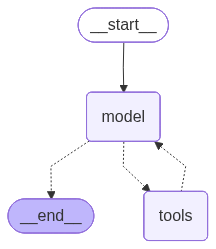

In [18]:
from IPython.display import Image, display

png_bytes = fs_agent.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [19]:
def normalize_messages(messages: List[Any]) -> List[Dict[str, str]]:
    """Convert LangChain message objects (or dicts) into [{'role','content'}] dicts."""
    out = []
    for m in messages:
        # Already a dict?
        if isinstance(m, dict):
            out.append({"role": m.get("role", "unknown"), "content": m.get("content", "")})
            continue

        # LangChain BaseMessage-like objects
        role = getattr(m, "type", None) or m.__class__.__name__.lower()
        content = getattr(m, "content", "")

        # Normalize role names
        if role in ("human", "user", "humanmessage"):
            role = "user"
        elif role in ("ai", "assistant", "aimessage"):
            role = "assistant"
        elif role in ("system", "systemmessage"):
            role = "system"

        out.append({"role": role, "content": content})
    return out

In [20]:
from langchain_core.callbacks import BaseCallbackHandler
from uuid import uuid4


class EpisodicToolLogger(BaseCallbackHandler):
    """Logs tool calls to episodic/tool_outputs/<run_id>/...json"""

    def __init__(self, run_id: str, episodic_dir: str = "episodic", max_chars: int = 50_000):
        self.run_id = run_id
        self.max_chars = max_chars
        self.out_dir = Path(episodic_dir) / "tool_outputs" / run_id
        self.out_dir.mkdir(parents=True, exist_ok=True)
        self._pending = {}  # call_id -> dict

    def on_tool_start(self, serialized, input_str=None, **kwargs):
        tool_name = (serialized or {}).get("name") or "unknown_tool"
        call_id = kwargs.get("run_id") or str(uuid4())

        self._pending[call_id] = {
            "ts_utc": datetime.now(timezone.utc).isoformat(),
            "tool": tool_name,
            "input": input_str,
        }

    def on_tool_end(self, output, **kwargs):
        call_id = kwargs.get("run_id")
        record = self._pending.pop(call_id, {
            "ts_utc": datetime.now(timezone.utc).isoformat(),
            "tool": "unknown_tool",
            "input": None,
        })

        # Make output JSON-safe + bounded
        try:
            out = output if isinstance(output, (dict, list, str, int, float, bool)) else str(output)
        except Exception:
            out = "<unserializable output>"

        out_str = out if isinstance(out, str) else json.dumps(out, ensure_ascii=False)
        if len(out_str) > self.max_chars:
            out_str = out_str[: self.max_chars] + "\n\n[TRUNCATED]"

        record["output"] = out_str

        ts = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")
        fname = f"{ts}_{record['tool']}.json"
        (self.out_dir / fname).write_text(json.dumps(record, indent=2, ensure_ascii=False), encoding="utf-8")


## 1.7 Run Agent

In [21]:
from typing import Any, List

def chat(run_id: str, max_context_tokens: int = 128_000, threshold: float = 0.80) -> None:
    """
    Conversational chat loop with:
    - transcript persisted every turn (conversation_to_file)
    - tool outputs logged every turn (EpisodicToolLogger -> episodic/tool_outputs/<run_id>/)
    - context monitoring every turn (monitor_context_window)
    - auto-summarise at threshold (summarise_conversation_to_file)
      and rotate the working context to a compact summary + transcript reference.
    """
    model_name = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    tool_logger = EpisodicToolLogger(run_id=run_id, episodic_dir="episodic")

    # Context for the agent (can be rotated after summarisation)
    messages: List[Any] = []

    print("FSAgent chat started. Type 'exit' to stop.\n")

    while True:
        user_text = input("You: ").strip()
        if user_text.lower() in {"exit", "quit"}:
            print("\nSaved conversation transcript.")
            break

        # 1) append user message to transcript (timestamped)
        conversation_to_file.invoke({
            "run_id": run_id,
            "messages": [{"role": "user", "content": user_text, "ts": _ts_utc()}],
        })

        # Add to agent context
        messages.append({"role": "user", "content": user_text})

        # Monitor context
        status = monitor_context_window.invoke(
            {
                "messages": normalize_messages(messages),
                "model_name": model_name,
                "max_context_tokens": max_context_tokens,
            }
        )

        # Summarise if needed (and rotate context)
        if status["utilization_ratio"] >= threshold:
            pack = summarise_conversation_to_file.invoke(
                {"run_id": run_id, "messages": []}  # summariser will read transcript file (see below)
            )
            summary = pack["summary"]
            transcript_path = pack["transcript_path"]
            summary_path = pack["summary_path"]

            # record the summarisation event in transcript
            conversation_to_file.invoke({
                "run_id": run_id,
                "messages": [{
                    "role": "system",
                    "content": f"Context summarised.\nTranscript: {transcript_path}\nSummary: {summary_path}",
                    "ts": _ts_utc()
                }],
            })

            # Rotate agent context to summary + pointer
            messages = [
                {
                    "role": "developer",
                    "content": (
                        "Conversation has been summarised to control context window usage.\n\n"
                        f"Full transcript path: {transcript_path}\n"
                        f"Summary path: {summary_path}\n\n"
                        "Summary:\n"
                        f"{summary}\n\n"
                        "If you need details, use tail_file/read_file_range first, then read_file."
                    ),
                },
                {"role": "user", "content": user_text},
            ]

        # Run agent (tool outputs logged by callback)
        state = fs_agent.invoke(
            {"messages": messages},
            config={"callbacks": [tool_logger]},
        )

        messages = state.get("messages", messages)

        # append assistant message to transcript
        last = messages[-1]
        assistant_text = last.get("content") if isinstance(last, dict) else getattr(last, "content", str(last))
        conversation_to_file.invoke({
            "run_id": run_id,
            "messages": [{"role": "assistant", "content": str(assistant_text), "ts": _ts_utc()}],
        })

        print(f"\nFSAgent: {assistant_text}\n")


In [22]:
# Benchmark version of chat() - non-interactive with auto-summarization
import time
from typing import Tuple

def chat_benchmark(
    run_id: str,
    query: str,
    messages: List[Any] = None,
    max_context_tokens: int = 128_000,
    threshold: float = 0.80,
    auto_summarize: bool = True,
) -> Tuple[str, float, bool, List[Any]]:
    """
    Non-interactive benchmark version of chat() with auto-summarization.
    Returns: (response_text, latency_ms, success, updated_messages)
    """
    start_time = time.perf_counter()
    model_name = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    tool_logger = EpisodicToolLogger(run_id=run_id, episodic_dir="episodic")
    
    if messages is None:
        messages = []
    
    try:
        conversation_to_file.invoke({
            "run_id": run_id,
            "messages": [{"role": "user", "content": query, "ts": _ts_utc()}],
        })
        messages.append({"role": "user", "content": query})
        
        status = monitor_context_window.invoke({
            "messages": normalize_messages(messages),
            "model_name": model_name,
            "max_context_tokens": max_context_tokens,
        })
        
        if auto_summarize and status["utilization_ratio"] >= threshold:
            print(f"    [SUMMARIZING] Context at {status['utilization_ratio']:.1%}")
            pack = summarise_conversation_to_file.invoke({"run_id": run_id, "messages": []})
            messages = [
                {"role": "developer", "content": f"Summary: {pack['summary']}"},
                {"role": "user", "content": query},
            ]
        
        state = fs_agent.invoke({"messages": messages}, config={"callbacks": [tool_logger]})
        messages = state.get("messages", messages)
        
        last = messages[-1]
        assistant_text = last.get("content") if isinstance(last, dict) else getattr(last, "content", str(last))
        
        conversation_to_file.invoke({
            "run_id": run_id,
            "messages": [{"role": "assistant", "content": str(assistant_text), "ts": _ts_utc()}],
        })
        
        latency_ms = (time.perf_counter() - start_time) * 1000
        return str(assistant_text), latency_ms, True, messages
        
    except Exception as e:
        latency_ms = (time.perf_counter() - start_time) * 1000
        return f"Error: {str(e)}", latency_ms, False, messages

print("[OK] chat_benchmark() defined")

[OK] chat_benchmark() defined


In [23]:
chat(run_id="fsagent_session_0010", max_context_tokens=128_000, threshold=0.80)


FSAgent chat started. Type 'exit' to stop.


Saved conversation transcript.


> 💡 **Key Takeaways**
> - The system prompt should explain the memory architecture so the agent uses tools appropriately
> - Persist every turn immediately—don't batch writes that could be lost on crash
> - Session IDs (`run_id`) enable resuming conversations across restarts

# Part 2: MemAgent (Database backed Agent)

## What You Will Learn

This section demonstrates how to build a **database-backed research agent** using Oracle AI Database for persistent, queryable memory. By the end of Part 2, you will understand:

### Architecture Overview

The MemAgent uses two types of database storage:
- **SQL Tables** - Structured storage for conversation history and tool logs
- **Vector Stores** - Embedding-based storage for semantic search over the knowledge base

### Step-by-Step Implementation

**2.1 Setting Up Oracle AI Database**
- Launch Oracle Database in a Docker container with vector search extensions
- Establish a connection pool with retry logic for reliability
- Configure the database user and permissions for vector operations

**2.2 Creating Data Stores with LangChain and Oracle AI Database**

  **2.2.1 Conversational Memory Table**
  - Design a SQL schema for storing chat history (thread_id, role, content, timestamp)
  - Implement thread-based isolation for multi-user/multi-session support
  - Create a tool logging table to track agent actions for debugging

  **2.2.2 Vector Stores with Hybrid Search**
  - Initialize `OracleVS` vector store with HuggingFace embeddings
  - Configure HNSW indexes for fast approximate nearest neighbor search
  - Enable hybrid search combining vector similarity with keyword filtering

**2.3 Memory Manager**
- Build the `MemoryManager` class that abstracts all database operations
- Implement `write_conversational_history()` for persisting chat turns
- Implement `load_conversational_history()` for retrieving thread context
- Implement `write_knowledge_base()` and `read_knowledge_base()` for semantic memory

**2.4 Creating The Agent**
- Create standalone tool wrappers that delegate to the MemoryManager
- Build `fetch_and_save_paper_to_kb_db()` to chunk and embed papers
- Configure the LangChain agent with database-aware tools
- Implement the chat loop with automatic history loading and persistence

### MemAgent Tools

| Tool | What it does | Storage |
|---|---|---|
| **arxiv_search_candidates(query, k)** | Searches arXiv for candidate papers | None (API call) |
| **fetch_and_save_paper_to_kb_db(arxiv_id)** | Fetches paper, chunks text, and stores embeddings in vector store | Vector store |
| **search_knowledge_base(query, k)** | Semantic search over stored papers using vector similarity | Vector store |
| **store_to_knowledge_base(text, metadata)** | Manually store text with metadata in the knowledge base | Vector store |

### Key Differences from FSAgent

| Aspect | FSAgent (Filesystem) | MemAgent (Database) |
|--------|---------------------|---------------------|
| **Search** | Keyword/grep-based | Vector similarity (semantic) |
| **Persistence** | Markdown files | SQL tables + vector indexes |
| **Scalability** | Directory traversal | Indexed queries |
| **Query Language** | File paths + regex | SQL + vector similarity |
| **Setup Complexity** | None (filesystem) | Requires database server |

## 2.1 Setting Up Oracle AI Database

Before running the setup code, ensure you have Docker installed and pull the Oracle Free container image with vector search capabilities. This image includes Oracle AI Database  Free with built-in vector operations.

```bash
docker pull ghcr.io/gvenzl/oracle-free:23.26.0
docker run -d --name oracle-free -p 1521:1521 -p 5500:5500 -e ORACLE_PASSWORD='YourStrongPassword' ghcr.io/gvenzl/oracle-free:23.26.0
docker logs -f oracle-free
```

First-time startup may take a few minutes as Oracle initializes the database files. Once ready, the code below will establish a connection to the running container.

In [24]:
import subprocess, time
import oracledb

IMAGE = "ghcr.io/gvenzl/oracle-free:23.26.0"
CONTAINER = "oracle-free"
PDB = "FREEPDB1"
PORT = 1521

def sh(*cmd, check=True, capture=True, text=True):
    return subprocess.run(cmd, check=check, capture_output=capture, text=text)

def ensure_running(container=CONTAINER, image=IMAGE, oracle_pwd=None):
    # Docker reachable?
    sh("docker", "info")

    # Container exists?
    r = sh("docker", "ps", "-a", "--filter", f"name=^{container}$", "--format", "{{.Names}}", check=False)
    if r.stdout.strip() == container:
        r2 = sh("docker", "inspect", "-f", "{{.State.Running}}", container, check=False)
        if r2.stdout.strip().lower() != "true":
            sh("docker", "start", container)
        return

    # Otherwise create it (minimal, safe defaults)
    if not oracle_pwd:
        raise ValueError("Set oracle_pwd (SYS/SYSTEM password) to create a fresh container.")
    sh(
        "docker", "run", "-d",
        "--name", container,
        "-p", f"{PORT}:1521",
        "-p", "5500:5500",
        "--shm-size=1g",
        "-e", f"ORACLE_PASSWORD={oracle_pwd}",
        image
    )

def wait_ready(container=CONTAINER, pdb=PDB, timeout_s=600):
    """Deterministic readiness check: instance OPEN + PDB READ WRITE."""
    deadline = time.time() + timeout_s
    cmd = (
        "export ORACLE_SID=FREE; "
        "sqlplus -s / as sysdba <<'SQL'\n"
        "set heading off feedback off pages 0 verify off echo off\n"
        "select status from v$instance;\n"
        f"select open_mode from v$pdbs where name='{pdb}';\n"
        "exit\n"
        "SQL"
    )
    while time.time() < deadline:
        r = sh("docker", "exec", container, "bash", "-lc", cmd, check=False)
        out = (r.stdout or "").upper()
        if "OPEN" in out and "READ WRITE" in out:
            return
        time.sleep(3)
    raise TimeoutError(f"DB not ready after {timeout_s}s. Try: docker logs -f {container}")

def get_vector_memory_size(container=CONTAINER) -> int:
    """Return vector_memory_size in bytes (0 if unset)."""
    cmd = (
        "export ORACLE_SID=FREE; "
        "sqlplus -s / as sysdba <<'SQL'\n"
        "set heading off feedback off pages 0 verify off echo off\n"
        "select value from v$parameter where name='vector_memory_size';\n"
        "exit\n"
        "SQL"
    )
    r = sh("docker", "exec", container, "bash", "-lc", cmd, check=False)
    raw = (r.stdout or "").strip()
    # sqlplus output can include blank lines; grab the last numeric token
    tokens = [t for t in raw.split() if t.isdigit()]
    return int(tokens[-1]) if tokens else 0

def configure_vector_memory(container=CONTAINER, size="1G", timeout_s=600):
    """
    Ensure Vector Pool is enabled for HNSW/ANN operations by setting VECTOR_MEMORY_SIZE
    (SPFILE) and restarting the DB if needed.

    size: e.g. "512M", "1G"
    """
    current = get_vector_memory_size(container)
    if current and current > 0:
        return False  # no restart needed

    sql = f"""
alter system set vector_memory_size={size} scope=spfile sid='*';
shutdown immediate;
startup;
"""
    sh("docker", "exec", container, "bash", "-lc", f"export ORACLE_SID=FREE; sqlplus -s / as sysdba <<'SQL'\n{sql}\nSQL")
    wait_ready(container=container, pdb=PDB, timeout_s=timeout_s)
    return True  # restart happened

def create_vector_user(container=CONTAINER, vector_pwd="VectorPwd_2025"):
    sql = f"""
ALTER SESSION SET CONTAINER = {PDB};
BEGIN
  EXECUTE IMMEDIATE 'CREATE USER VECTOR IDENTIFIED BY "{vector_pwd}"';
EXCEPTION
  WHEN OTHERS THEN
    IF SQLCODE != -01920 AND SQLCODE != -01921 AND SQLCODE != -01918 AND SQLCODE != -00955 THEN
      RAISE;
    END IF;
END;
/
GRANT CREATE SESSION, CREATE TABLE, CREATE SEQUENCE, CREATE VIEW TO VECTOR;
GRANT UNLIMITED TABLESPACE TO VECTOR;
"""
    sh("docker", "exec", container, "bash", "-lc",
       f'export ORACLE_SID=FREE; echo "{sql}" | sqlplus -s / as sysdba')

def test_connection(vector_pwd="VectorPwd_2025"):
    conn = oracledb.connect(user="VECTOR", password=vector_pwd, dsn=f"127.0.0.1:{PORT}/{PDB}")
    with conn.cursor() as cur:
        cur.execute("select sys_context('userenv','con_name') from dual")
        con_name = cur.fetchone()[0]
    conn.close()
    return con_name

def setup(oracle_pwd=None, vector_pwd="VectorPwd_2025", vector_memory_size="1G"):
    ensure_running(oracle_pwd=oracle_pwd)
    wait_ready()

    restarted = configure_vector_memory(size=vector_memory_size)
    if restarted:
        print(f"🧠 Enabled Vector Pool (VECTOR_MEMORY_SIZE={vector_memory_size}) and restarted DB")

    create_vector_user(vector_pwd=vector_pwd)
    con_name = test_connection(vector_pwd=vector_pwd)
    print(f"✅ Ready. Connected as VECTOR to container: {con_name}")
    print(f"DSN: 127.0.0.1:{PORT}/{PDB}")


In [25]:
setup(oracle_pwd="YourStrongPassword", vector_pwd="VectorPwd_2025", vector_memory_size="1G")

✅ Ready. Connected as VECTOR to container: FREEPDB1
DSN: 127.0.0.1:1521/FREEPDB1


In [26]:
def connect_oracle(user, password, dsn="127.0.0.1:1521/FREEPDB1", program="langchain_oracledb_demo"):
    return oracledb.connect(user=user, password=password, dsn=dsn, program=program)

In [27]:
database_connection = connect_oracle(
    user="VECTOR",
    password="VectorPwd_2025",
    dsn="127.0.0.1:1521/FREEPDB1",
    program="devrel.content.filesystem_vs_dbs",
)

print("Using user:", database_connection.username)

Using user: VECTOR


> 💡 **Key Takeaways**
> - Use Docker for reproducible Oracle setup—no local installation required
> - Connection pooling with retry logic handles transient startup delays
> - Oracle 23ai Free includes vector operations at no cost for development

## 2.2 Creating Data Stores with LangChain and Oracle AI Database

With the database running, we now create the storage infrastructure. Oracle AI Database supports both traditional SQL tables and vector stores, allowing us to use the right tool for each memory type. We'll initialize the embedding model first, then set up structured tables for conversation history and a vector store for semantic knowledge retrieval.

In [28]:
from langchain_community.embeddings import HuggingFaceEmbeddings

# Initialize the embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-mpnet-base-v2"
)

/var/folders/8r/qvgk1jk97zdc9z1jjtdhm_440000gn/T/ipykernel_76924/2603100073.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [29]:
from langchain_oracledb.vectorstores import OracleVS
from langchain_oracledb.vectorstores.oraclevs import create_index
from langchain_community.vectorstores.utils import DistanceStrategy

# Table names for each memory type
CONVERSATIONAL_TABLE   = "CONVERSATIONAL_MEMORY" # Episodic memory
KNOWLEDGE_BASE_TABLE   = "SEMANTIC_MEMORY" # Semantic memory
LOGS_TABLE = "LOGS_MEMORY" # Episodic memory
SUMMARY_TABLE = "SUMMARY_MEMORY" # Episodic memory

ALL_TABLES = [
    CONVERSATIONAL_TABLE, 
    KNOWLEDGE_BASE_TABLE, 
    LOGS_TABLE, 
    SUMMARY_TABLE]

# Drop existing tables to start fresh
for table in ALL_TABLES:
    try:
        with database_connection.cursor() as cur:
            cur.execute(f"DROP TABLE {table} PURGE")
    except Exception as e:
        if "ORA-00942" in str(e):
            print(f"  - {table} (not exists)")
        else:
            print(f"  [FAIL] {table}: {e}")
            
database_connection.commit()

  - LOGS_MEMORY (not exists)


> 💡 **Key Takeaways**
> - Choose storage type based on query pattern: SQL for exact lookups, vectors for semantic search
> - Initialize embeddings once and reuse—model loading is expensive
> - LangChain's Oracle integration handles connection and transaction management

### 2.2.1 Create conversational memory table

Conversation history requires structured storage with fast lookups by thread ID. We create a SQL table with columns for thread identification, role (user/assistant), message content, and timestamps. A separate tool logging table tracks every tool invocation, enabling debugging and analysis of agent behavior.

In [30]:
from typing import Sequence, Tuple, Optional

ColumnSpec = Tuple[str, str]
IndexSpec  = Tuple[str, Sequence[str]]

def create_table(
    conn,
    table_name: str,
    columns: Sequence[ColumnSpec],
    indexes: Optional[Sequence[IndexSpec]] = None,
    drop_if_exists: bool = True,
) -> str:
    """
    Generic Oracle table creator with optional indexes.

    Args:
        conn: Oracle DB connection (python-oracledb)
        table_name: Table name (optionally schema-qualified)
        columns: List of (column_name, sql_type_and_constraints)
                 e.g. ("id", "VARCHAR2(32) DEFAULT SYS_GUID() PRIMARY KEY")
        indexes: List of (index_suffix, [columns...])
                 Index name will be: idx_<table>_<suffix>
        drop_if_exists: Drop table first (best-effort)

    Returns:
        table_name
    """
    if not columns:
        raise ValueError("columns must be non-empty")

    with conn.cursor() as cur:
        if drop_if_exists:
            try:
                cur.execute(f"DROP TABLE {table_name} PURGE")
            except Exception:
                pass

        ddl_cols = ",\n                ".join(
            f"{col_name} {col_def}" for col_name, col_def in columns
        )

        cur.execute(f"""
            CREATE TABLE {table_name} (
                {ddl_cols}
            )
        """)

        if indexes:
            for suffix, cols in indexes:
                if not cols:
                    continue
                idx_name = f"idx_{table_name.lower()}_{suffix}".replace(".", "_")
                col_list = ", ".join(cols)
                cur.execute(f"CREATE INDEX {idx_name} ON {table_name}({col_list})")

    conn.commit()
    print(f"Table {table_name} created successfully" + (f" with {len(indexes)} indexes" if indexes else ""))
    return table_name


In [31]:
def create_conversational_history_table(conn, table_name: str = "CONVERSATIONAL_MEMORY"):
    columns = [
        ("id", "VARCHAR2(32) DEFAULT RAWTOHEX(SYS_GUID()) PRIMARY KEY"),
        ("thread_id", "VARCHAR2(100) NOT NULL"),
        ("role", "VARCHAR2(50) NOT NULL"),
        ("content", "CLOB NOT NULL"),
        ("timestamp", "TIMESTAMP DEFAULT CURRENT_TIMESTAMP"),
        ("metadata", "CLOB"),
        ("created_at", "TIMESTAMP DEFAULT CURRENT_TIMESTAMP"),
        ("summary_id", "VARCHAR2(100) DEFAULT NULL"),
    ]
    indexes = [
        ("thread_id", ["thread_id"]),
        ("timestamp", ["timestamp"]),
    ]
    return create_table(conn, table_name, columns, indexes)


In [32]:
def create_tool_log_table(conn, table_name: str = "TOOL_LOGS"):
    columns = [
        ("id", "VARCHAR2(32) DEFAULT RAWTOHEX(SYS_GUID()) PRIMARY KEY"),
        ("run_id", "VARCHAR2(100) NOT NULL"),
        ("tool_name", "VARCHAR2(200) NOT NULL"),
        ("input", "CLOB"),
        ("output", "CLOB"),
        ("status", "VARCHAR2(30)"),
        ("error", "CLOB"),
        ("ts_utc", "TIMESTAMP DEFAULT CURRENT_TIMESTAMP"),
        ("metadata", "CLOB"),
    ]
    indexes = [
        ("run_id", ["run_id"]),
        ("tool_name", ["tool_name"]),
        ("ts_utc", ["ts_utc"]),
    ]
    return create_table(conn, table_name, columns, indexes)


In [33]:
CONVERSATION_HISTORY_TABLE = create_conversational_history_table(database_connection)
TOOL_LOG_TABLE = create_tool_log_table(database_connection)

Table CONVERSATIONAL_MEMORY created successfully with 2 indexes
Table TOOL_LOGS created successfully with 3 indexes


> 💡 **Key Takeaways**
> - Thread-based isolation (`thread_id`) enables multi-user and multi-session support
> - Tool logging creates an audit trail for debugging agent behavior
> - Use CLOB type for content columns—VARCHAR2 has a 4000-byte limit

### 2.2.2 Create Vector Stores with Hybrid Search Capabilities

Unlike conversation history, the knowledge base benefits from semantic search—finding relevant content based on meaning rather than exact keywords. We use LangChain's `OracleVS` to create a vector store backed by Oracle's native vector operations. HNSW (Hierarchical Navigable Small World) indexes enable fast approximate nearest neighbor search at scale.

In [34]:
knowledge_base_vs = OracleVS(
    client=database_connection,
    embedding_function=embedding_model,
    table_name=KNOWLEDGE_BASE_TABLE,
    distance_strategy=DistanceStrategy.COSINE,
)

summary_vs = OracleVS(
    client=database_connection,
    embedding_function=embedding_model,
    table_name=SUMMARY_TABLE,
    distance_strategy=DistanceStrategy.COSINE,
)

In [35]:
def safe_create_index(conn, vs, idx_name):
    """Create index, skipping if it already exists."""
    try:
        create_index(
            client=conn,
            vector_store=vs,
            params={"idx_name": idx_name, "idx_type": "HNSW"}
        )
        print(f"  Created index: {idx_name}")
    except Exception as e:
        if "ORA-00955" in str(e):
            print(f"  [SKIP] Index already exists: {idx_name}")
        else:
            raise

In [36]:
print("Creating vector indexes...")
safe_create_index(database_connection, knowledge_base_vs, "kb_hnsw_cosine_idx")
safe_create_index(database_connection, summary_vs, "summary_hnsw_cosine_idx")
print("All indexes created!")

Creating vector indexes...
  Created index: kb_hnsw_cosine_idx
  Created index: summary_hnsw_cosine_idx
All indexes created!


> 💡 **Key Takeaways**
> - HNSW indexes trade perfect accuracy for dramatically faster search at scale
> - Create indexes after bulk loading data—index maintenance slows inserts
> - Vector similarity finds semantically related content even with different wording

## 2.3 Memory Manager

The `MemoryManager` class encapsulates all database operations behind a clean interface. It handles the complexity of SQL queries, vector similarity search, and connection management so the agent tools can remain simple. This abstraction also makes it easy to swap storage backends without changing tool implementations.

In [37]:
from langchain.tools import tool
from typing import List, Dict

class MemoryManager:
    """
    A simplified memory manager for AI agents using Oracle AI Database.
    
    Manages 5 types of memory:
    - Conversational: Chat history per thread (SQL table)
    - Knowledge Base: Searchable documents (Vector store)
    - Workflow: Execution patterns (Vector store)
    - Toolbox: Available tools (Vector store)
    - Entity: People, places, systems (Vector store)
    - Summary: Storing compressed context window
    """

    def __init__(self, conn, conversation_table: str, knowledge_base_vs, summary_vs, tool_log_table):
        self.conn = conn
        self.conversation_table = conversation_table
        self.knowledge_base_vs = knowledge_base_vs
        self.summary_vs = summary_vs
        self.tool_log_table = tool_log_table
    
    # ==================== CONVERSATIONAL MEMORY (SQL) ====================
    
    def write_conversational_memory(self, content: str, role: str, thread_id: str) -> str:
        """Store a message in conversation history."""
        thread_id = str(thread_id)
        with self.conn.cursor() as cur:
            id_var = cur.var(str)
            cur.execute(f"""
                INSERT INTO {self.conversation_table} (thread_id, role, content, metadata, timestamp)
                VALUES (:thread_id, :role, :content, :metadata, CURRENT_TIMESTAMP)
                RETURNING id INTO :id
            """, {"thread_id": thread_id, "role": role, "content": content, "metadata": "{}", "id": id_var})
            record_id = id_var.getvalue()[0] if id_var.getvalue() else None
        self.conn.commit()
        return record_id
    
    def load_conversational_history(self, thread_id: str, limit: int = 50) -> List[Dict[str, str]]:
        """Load conversation history for a thread as a list of message dicts."""
        thread_id = str(thread_id)
        with self.conn.cursor() as cur:
            cur.execute(f"""
                SELECT role, content FROM {self.conversation_table}
                WHERE thread_id = :thread_id AND summary_id IS NULL
                ORDER BY timestamp ASC
                FETCH FIRST :limit ROWS ONLY
            """, {"thread_id": thread_id, "limit": limit})
            results = cur.fetchall()
        
        return [{"role": str(role), "content": content.read() if hasattr(content, 'read') else str(content)} for role, content in results]
    
    def mark_as_summarized(self, thread_id: str, summary_id: str):
        """Mark all unsummarized messages in a thread as summarized."""
        thread_id = str(thread_id)
        with self.conn.cursor() as cur:
            cur.execute(f"""
                UPDATE {self.conversation_table}
                SET summary_id = :summary_id
                WHERE thread_id = :thread_id AND summary_id IS NULL
            """, {"summary_id": summary_id, "thread_id": thread_id})
        self.conn.commit()
        print(f"  Marked messages as summarized (summary_id: {summary_id})")
    
    # ==================== KNOWLEDGE BASE (Vector Store) ====================
    
    def write_knowledge_base(self, text: str, metadata_json: str = "{}"):
        """Store text in knowledge base with metadata (metadata_json should be a JSON string)."""
        metadata = json.loads(metadata_json)
        self.knowledge_base_vs.add_texts([text], [metadata])

    
    def read_knowledge_base(self, query: str, k: int = 5) -> str:
        """Search knowledge base for relevant content."""
        results = self.knowledge_base_vs.similarity_search(query, k=k)
        content = "\n".join([doc.page_content for doc in results])
        return f"""## Knowledge Base Memory: This are general information that is relevant to the question
### How to use: Use the knowledge base as background information that can help answer the question

{content}"""

    #==================== TOOL LOG ====================

    @tool
    def write_tool_log(self, tool_name: str, input: str, output: str, status: str, error: str, metadata: dict):
        """Store a tool call in the tool log."""
        thread_id = str(thread_id)
        with self.conn.cursor() as cur:
            id_var = cur.var(str)
            cur.execute(f"""
                INSERT INTO {self.tool_log_table}
                VALUES (:tool_name, :input, :output, :status, :error, :metadata)
                RETURNING id INTO :id
            """, {"tool_name": tool_name, "input": input, "output": output, "status": status, "error": error, "metadata": "{}", "id": id_var})
            record_id = id_var.getvalue()[0] if id_var.getvalue() else None
        self.conn.commit()
        return record_id
    
    
    # ==================== SUMMARY (Vector Store) ====================
    
    def write_summary(self, summary_id: str, full_content: str, summary: str, description: str):
        """Store a summary with its original content."""
        self.summary_vs.add_texts(
            [f"{summary_id}: {description}"],
            [{"id": summary_id, "full_content": full_content, "summary": summary, "description": description}]
        )
        return summary_id
    
    def read_summary_memory(self, summary_id: str) -> str:
        """Retrieve a specific summary by ID (just-in-time retrieval)."""
        results = self.summary_vs.similarity_search(
            summary_id, 
            k=5, 
            filter={"id": summary_id}
        )
        if not results:
            return f"Summary {summary_id} not found."
        doc = results[0]
        return doc.metadata.get('summary', 'No summary content.')
    
    def read_summary_context(self, query: str = "", k: int = 5) -> str:
        """Get available summaries for context window (IDs + descriptions only)."""
        results = self.summary_vs.similarity_search(query or "summary", k=k)
        if not results:
            return "## Summary Memory\nNo summaries available."
        
        lines = ["## Summary Memory", "Use expand_summary(id) to get full content:"]
        for doc in results:
            sid = doc.metadata.get('id', '?')
            desc = doc.metadata.get('description', 'No description')
            lines.append(f"  - [ID: {sid}] {desc}")
        return "\n".join(lines)

In [38]:
memory_manager = MemoryManager(
    conn=database_connection,
    conversation_table=CONVERSATION_HISTORY_TABLE, 
    knowledge_base_vs=knowledge_base_vs,
    tool_log_table=TOOL_LOG_TABLE,
    summary_vs=summary_vs
)

In [39]:
# Utility: Clear all tables
def clear_all_tables(conn, confirm: bool = True) -> dict:
    """Clear all MemAgent tables without dropping them."""
    tables = [CONVERSATION_HISTORY_TABLE, TOOL_LOG_TABLE, KNOWLEDGE_BASE_TABLE, SUMMARY_TABLE]
    results = {}
    if confirm:
        print("Tables to clear:")
        for t in tables:
            try:
                with conn.cursor() as cur:
                    cur.execute(f"SELECT COUNT(*) FROM {t}")
                    print(f"  - {t}: {cur.fetchone()[0]} rows")
            except: pass
    for t in tables:
        try:
            with conn.cursor() as cur:
                cur.execute(f"SELECT COUNT(*) FROM {t}")
                count = cur.fetchone()[0]
                cur.execute(f"DELETE FROM {t}")
                conn.commit()
                results[t] = count
                print(f"[OK] Cleared {t}: {count} rows")
        except Exception as e:
            results[t] = f"ERROR: {e}"
    return results

print("[OK] clear_all_tables() defined")

[OK] clear_all_tables() defined


In [40]:
from datetime import datetime, timezone
from langchain_core.tools import tool
from langchain_community.document_loaders import ArxivLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

@tool
def fetch_and_save_paper_to_kb_db(
    arxiv_id: str,
    chunk_size: int = 1500,
    chunk_overlap: int = 200,
) -> str:
    """
    Fetch full arXiv paper text (PDF -> text) and store it into the OracleVS
    knowledge base table as chunked records (avoids routing full content via the LLM).

    Writes to: KNOWLEDGE_BASE_TABLE (via knowledge_base_vs.add_texts)
    """

    # 1) Load full paper text from arXiv (PDF -> text)
    loader = ArxivLoader(
        query=arxiv_id,
        load_max_docs=1,
        doc_content_chars_max=None,  # "no truncation" in current LangChain docs :contentReference[oaicite:1]{index=1}
    )
    docs = loader.load()
    if not docs:
        return f"No documents found for arXiv id: {arxiv_id}"

    doc = docs[0]

    title = (
        doc.metadata.get("Title")
        or doc.metadata.get("title")
        or f"arXiv {arxiv_id}"
    )

    # Normalize common arxiv metadata keys
    entry_id = doc.metadata.get("Entry ID") or doc.metadata.get("entry_id") or ""
    published = doc.metadata.get("Published") or doc.metadata.get("published") or ""
    authors = doc.metadata.get("Authors") or doc.metadata.get("authors") or ""

    full_text = doc.page_content or ""
    if not full_text.strip():
        return f"Loaded arXiv {arxiv_id} but extracted empty text (PDF parsing issue)."

    # 2) Chunk (important: embeddings have input limits; chunking prevents failures/truncation)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )
    chunks = splitter.split_text(full_text)

    # 3) Store chunks into OracleVS (vector store table)
    ts_utc = datetime.now(timezone.utc).isoformat()
    metadatas = []
    for i in range(len(chunks)):
        metadatas.append(
            {
                "source": "arxiv",
                "arxiv_id": arxiv_id,
                "title": title,
                "entry_id": entry_id,
                "published": str(published),
                "authors": str(authors),
                "chunk_id": i,
                "num_chunks": len(chunks),
                "ingested_ts_utc": ts_utc,
            }
        )

    # OracleVS typically supports add_texts(texts, metadatas)
    knowledge_base_vs.add_texts(chunks, metadatas)

    return (
        f"Saved arXiv {arxiv_id} to {KNOWLEDGE_BASE_TABLE}: "
        f"{len(chunks)} chunks (title: {title})."
    )


> 💡 **Key Takeaways**
> - Encapsulate database logic in a manager class—tools should be thin wrappers
> - Handle Oracle LOB objects with `.read()` before returning content as strings
> - The manager pattern makes it easy to mock storage for testing

## 2.4 Creating The Agent

With the memory infrastructure in place, we assemble the MemAgent. This involves creating standalone tool wrapper functions (since `@tool` cannot decorate class methods), building a paper ingestion tool that chunks and embeds documents, and configuring the chat loop to automatically load conversation history at startup.

In [41]:
# Initialize the agent

import os
from langchain.agents import create_agent
from langchain.tools import tool

@tool
def search_knowledge_base(query: str, k: int = 5) -> str:
    """Search knowledge base for relevant content."""
    return memory_manager.read_knowledge_base(query, k)

@tool  
def store_to_knowledge_base(text: str, metadata_json: str = "{}") -> str:
    """Store text in knowledge base with metadata (metadata_json should be a JSON string)."""
    memory_manager.write_knowledge_base(text, metadata_json)
    return f"Successfully stored text to knowledge base."

MEM_AGENT = create_agent(
    model=f"openai:{os.getenv('OPENAI_MODEL', 'gpt-4o-mini')}",
    tools=[search_knowledge_base, store_to_knowledge_base, arxiv_search_candidates, fetch_and_save_paper_to_kb_db],
)

In [42]:

import os
import json
import uuid
from datetime import datetime, timezone
from typing import Any, Dict, List, Optional
from langchain_openai import ChatOpenAI
from langchain_core.callbacks import BaseCallbackHandler


def _ts_utc() -> str:
    return datetime.now(timezone.utc).isoformat()


def normalize_messages_any(messages: List[Any]) -> List[Dict[str, str]]:
    """
    Convert LangChain message objects (or dicts) into [{'role','content'}] dicts.
    Includes tool messages too (role='tool') so context monitoring is accurate.
    """
    out: List[Dict[str, str]] = []
    for m in messages:
        if isinstance(m, dict):
            out.append({"role": m.get("role", "unknown"), "content": m.get("content", "")})
            continue

        # LangChain BaseMessage-like
        msg_type = getattr(m, "type", None) or m.__class__.__name__.lower()
        content = getattr(m, "content", "")

        if msg_type in ("human", "user", "humanmessage"):
            role = "user"
        elif msg_type in ("ai", "assistant", "aimessage"):
            role = "assistant"
        elif msg_type in ("system", "systemmessage"):
            role = "system"
        elif msg_type in ("tool", "toolmessage"):
            role = "tool"
        else:
            role = msg_type  # best effort

        out.append({"role": role, "content": content})
    return out


def _extract_last_assistant_text(messages: List[Any]) -> str:
    """Find the last assistant/AI message in a mixed message list."""
    for m in reversed(messages):
        if isinstance(m, dict):
            if m.get("role") in {"assistant", "ai"}:
                return str(m.get("content", ""))
            continue

        msg_type = getattr(m, "type", None) or m.__class__.__name__.lower()
        if msg_type in {"ai", "assistant", "aimessage"}:
            return str(getattr(m, "content", ""))
    # fallback
    last = messages[-1] if messages else ""
    return str(last.get("content")) if isinstance(last, dict) else str(getattr(last, "content", last))


class DBToolLogger(BaseCallbackHandler):
    """
    Logs tool calls to an Oracle table (TOOL_LOG_TABLE).

    Schema expected (matches your create_tool_log_table):
      (id, run_id, tool_name, input, output, status, error, ts_utc, metadata)
    """

    def __init__(
        self,
        conn,
        tool_log_table: str,
        run_id: str,
        max_chars: int = 50_000,
    ):
        self.conn = conn
        self.table = tool_log_table
        self.run_id = run_id
        self.max_chars = max_chars
        self._pending: Dict[str, Dict[str, Any]] = {}  # tool_run_id -> record

    def on_tool_start(self, serialized, input_str=None, **kwargs):
        tool_name = (serialized or {}).get("name") or "unknown_tool"
        tool_run_id = kwargs.get("run_id") or kwargs.get("tool_call_id") or uuid.uuid4().hex

        self._pending[tool_run_id] = {
            "tool_run_id": tool_run_id,
            "tool_name": tool_name,
            "input": input_str,
            "ts_utc": _ts_utc(),
        }

    def on_tool_end(self, output, **kwargs):
        tool_run_id = kwargs.get("run_id") or kwargs.get("tool_call_id")
        rec = self._pending.pop(tool_run_id, None) or {
            "tool_run_id": tool_run_id or uuid.uuid4().hex,
            "tool_name": "unknown_tool",
            "input": None,
            "ts_utc": _ts_utc(),
        }

        # JSON-safe output + truncation
        try:
            out_obj = output if isinstance(output, (dict, list, str, int, float, bool)) else str(output)
        except Exception:
            out_obj = "<unserializable output>"

        out_str = out_obj if isinstance(out_obj, str) else json.dumps(out_obj, ensure_ascii=False)
        if len(out_str) > self.max_chars:
            out_str = out_str[: self.max_chars] + "\n\n[TRUNCATED]"

        self._insert_tool_log(
            tool_name=rec["tool_name"],
            input_text=rec.get("input"),
            output_text=out_str,
            status="OK",
            error_text=None,
            ts_utc=rec["ts_utc"],
            metadata={"tool_run_id": str(rec["tool_run_id"])},
        )

    def on_tool_error(self, error, **kwargs):
        tool_run_id = kwargs.get("run_id") or kwargs.get("tool_call_id")
        rec = self._pending.pop(tool_run_id, None) or {
            "tool_run_id": tool_run_id or uuid.uuid4().hex,
            "tool_name": "unknown_tool",
            "input": None,
            "ts_utc": _ts_utc(),
        }

        err_str = str(error)
        if len(err_str) > self.max_chars:
            err_str = err_str[: self.max_chars] + "\n\n[TRUNCATED]"

        self._insert_tool_log(
            tool_name=rec["tool_name"],
            input_text=rec.get("input"),
            output_text=None,
            status="ERROR",
            error_text=err_str,
            ts_utc=rec["ts_utc"],
            metadata={"tool_run_id": str(rec["tool_run_id"])},
        )

    def _insert_tool_log(
        self,
        tool_name: str,
        input_text: Optional[str],
        output_text: Optional[str],
        status: str,
        error_text: Optional[str],
        ts_utc: str,
        metadata: Optional[dict] = None,
    ):
        meta_str = json.dumps(metadata or {}, ensure_ascii=False)

        with self.conn.cursor() as cur:
            cur.execute(
                f"""
                INSERT INTO {self.table}
                    (run_id, tool_name, input, output, status, error, ts_utc, metadata)
                VALUES
                    (:run_id, :tool_name, :input, :output, :status, :error, CURRENT_TIMESTAMP, :metadata)
                """,
                {
                    "run_id": self.run_id,
                    "tool_name": tool_name,
                    "input": input_text,
                    "output": output_text,
                    "status": status,
                    "error": error_text,
                    "metadata": meta_str,
                },
            )
        self.conn.commit()


def _summarise_working_context_to_db(
    thread_id: str,
    working_messages: List[Any],
    model_name: str,
) -> Dict[str, str]:
    """
    Summarise what the model has been seeing (working context),
    store the summary in SUMMARY_TABLE (via summary_vs), and mark
    unsummarised conversational rows with summary_id.

    Returns: {summary_id, summary}
    """
    llm = ChatOpenAI(model=model_name, temperature=0)

    # Build a clean transcript view of the working context
    norm = normalize_messages_any(working_messages)
    transcript = "\n".join(
        [f"[{_ts_utc()}] {m['role'].upper()}: {m['content']}" for m in norm if m.get("content")]
    )

    prompt = (
        "Summarise this conversation for future continuity.\n\n"
        "Requirements:\n"
        "- Capture key facts, decisions, constraints.\n"
        "- Capture open questions / next steps.\n"
        "- Keep it concise (~200-400 words).\n"
        "- Do NOT invent details.\n\n"
        f"Thread: {thread_id}\n\n"
        "Conversation:\n"
        f"{transcript}"
    )

    summary_text = llm.invoke(prompt).content
    summary_id = uuid.uuid4().hex
    description = f"[thread:{thread_id}] conversation summary @ {_ts_utc()}"

    # Store summary in vector store-backed summary memory
    memory_manager.write_summary(
        summary_id=summary_id,
        full_content="",  # full transcript already lives in CONVERSATIONAL_MEMORY
        summary=summary_text,
        description=description,
    )

    # Mark DB conversation rows as summarised (so load_conversational_history ignores them)
    memory_manager.mark_as_summarized(thread_id=thread_id, summary_id=summary_id)

    # Optional: record an explicit system event in conversation history
    memory_manager.write_conversational_memory(
        content=f"Context summarised into summary_id={summary_id}.",
        role="system",
        thread_id=thread_id,
    )

    return {"summary_id": summary_id, "summary": summary_text}

## 2.5 Run Agent

In [43]:
def chat_memagent(
    thread_id: str,
    max_context_tokens: int = 128_000,
    threshold: float = 0.80,
) -> None:
    """
    Conversational chat loop for MemAgent (DB-backed memory):
    - user + assistant messages persisted to CONVERSATIONAL_MEMORY
    - tool outputs logged to TOOL_LOG_TABLE via DBToolLogger
    - context monitoring every turn
    - auto-summarise at threshold, store summary to SUMMARY_TABLE and mark rows summarised
    - rotate working context to (summary + pointer) to keep token usage stable
    """
    model_name = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

    tool_logger = DBToolLogger(
        conn=database_connection,
        tool_log_table=TOOL_LOG_TABLE,
        run_id=thread_id,  # group tool logs by thread/run
    )

    # Working context that gets passed to the agent (may contain tool messages)
    # Load existing conversation history if any
    existing_history = memory_manager.load_conversational_history(thread_id, limit=50)
    messages: List[Any] = existing_history

    if messages:
        print(f"Loaded {len(messages)} previous messages from thread '{thread_id}'.\n")
    
    print("MemAgent chat started. Type 'exit' to stop.\n")

    while True:
        user_text = input("You: ").strip()
        if user_text.lower() in {"exit", "quit"}:
            print("\nDone (conversation is stored in the database).")
            break

        # 1) Persist user message (DB transcript)
        memory_manager.write_conversational_memory(
            content=user_text,
            role="user",
            thread_id=thread_id,
        )

        # 2) Add to working context
        messages.append({"role": "user", "content": user_text})

        # 3) Monitor context usage (includes tool messages if present)
        status = monitor_context_window.invoke(
            {
                "messages": normalize_messages_any(messages),
                "model_name": model_name,
                "max_context_tokens": max_context_tokens,
            }
        )

        # 4) Summarise + rotate at threshold
        if status["utilization_ratio"] >= threshold:
            pack = _summarise_working_context_to_db(
                thread_id=thread_id,
                working_messages=messages,
                model_name=model_name,
            )
            summary_id = pack["summary_id"]
            summary = pack["summary"]

            # Rotate working context:
            # NOTE: this adds an extra system message AFTER the agent’s own system_prompt.
            # Keep it short + purely informational to avoid "overriding" behavior.
            messages = [
                {
                    "role": "system",
                    "content": (
                        "Working context was summarised to control context window usage.\n"
                        f"summary_id: {summary_id}\n\n"
                        "Summary:\n"
                        f"{summary}\n\n"
                        "If details are needed, ask to retrieve them from database memory."
                    ),
                },
                {"role": "user", "content": user_text},
            ]

        # 5) Invoke agent (tools logged to DB via callback)
        state = MEM_AGENT.invoke(
            {"messages": messages},
            config={"callbacks": [tool_logger]},
        )

        # Keep returned messages (includes tool call/result messages if any)
        messages = state.get("messages", messages)

        # 6) Persist assistant message (DB transcript)
        assistant_text = _extract_last_assistant_text(messages)
        memory_manager.write_conversational_memory(
            content=str(assistant_text),
            role="assistant",
            thread_id=thread_id,
        )

        print(f"\nMemAgent: {assistant_text}\n")

In [44]:
# Benchmark version of chat_memagent() - non-interactive

def chat_memagent_benchmark(
    thread_id: str,
    query: str,
    messages: List[Any] = None,
    max_context_tokens: int = 128_000,
    threshold: float = 0.80,
    auto_summarize: bool = True,
) -> Tuple[str, float, bool, List[Any]]:
    """
    Non-interactive benchmark version of chat_memagent().
    Returns: (response_text, latency_ms, success, updated_messages)
    """
    start_time = time.perf_counter()
    model_name = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    tool_logger = DBToolLogger(conn=database_connection, tool_log_table=TOOL_LOG_TABLE, run_id=thread_id)
    
    if messages is None:
        messages = memory_manager.load_conversational_history(thread_id, limit=50)
    
    try:
        memory_manager.write_conversational_memory(content=query, role="user", thread_id=thread_id)
        messages.append({"role": "user", "content": query})
        
        status = monitor_context_window.invoke({
            "messages": normalize_messages_any(messages),
            "model_name": model_name,
            "max_context_tokens": max_context_tokens,
        })
        
        if auto_summarize and status["utilization_ratio"] >= threshold:
            print(f"    [SUMMARIZING] Context at {status['utilization_ratio']:.1%}")
            pack = _summarise_working_context_to_db(thread_id=thread_id, working_messages=messages, model_name=model_name)
            messages = [
                {"role": "system", "content": f"Summary: {pack['summary']}"},
                {"role": "user", "content": query},
            ]
        
        state = MEM_AGENT.invoke({"messages": messages}, config={"callbacks": [tool_logger]})
        messages = state.get("messages", messages)
        
        assistant_text = _extract_last_assistant_text(messages)
        memory_manager.write_conversational_memory(content=str(assistant_text), role="assistant", thread_id=thread_id)
        
        latency_ms = (time.perf_counter() - start_time) * 1000
        return str(assistant_text), latency_ms, True, messages
        
    except Exception as e:
        latency_ms = (time.perf_counter() - start_time) * 1000
        return f"Error: {str(e)}", latency_ms, False, messages

print("[OK] chat_memagent_benchmark() defined")

[OK] chat_memagent_benchmark() defined


In [45]:
chat_memagent(thread_id="memagent_thread_0010", max_context_tokens=128_000, threshold=0.80)


MemAgent chat started. Type 'exit' to stop.


Done (conversation is stored in the database).


> 💡 **Key Takeaways**
> - Never use `@tool` on class methods—create standalone wrapper functions instead
> - Load conversation history at chat startup for seamless multi-session continuity
> - Chunk large documents before embedding—embedding models have token limits

# Part 3: Benchmarking FSAgent vs MemAgent

This section compares the filesystem-based agent (FSAgent) against the database-backed agent (MemAgent) with **end-to-end agent execution tests**:

1. **Search & Retrieve** - Agent searches for a paper and retrieves it
2. **Question Answering** - Agent answers questions about retrieved content
3. **Latency** - Time to complete full agent interactions
4. **Accuracy** - Quality of retrieved information



## 3.1 Benchmark Setup

In [46]:
# Benchmark Setup for End-to-End Agent Testing
import time
import statistics
import uuid
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
import matplotlib.pyplot as plt
import numpy as np

@dataclass
class AgentBenchmarkResult:
    """Store results from an agent benchmark run."""
    agent_type: str  # "fs" or "db"
    task: str  # "search_paper", "ask_question", etc.
    query: str
    response: str
    latency_ms: float
    success: bool
    expected_content: Optional[str] = None
    
    @property
    def contains_expected(self) -> bool:
        if not self.expected_content:
            return True
        return self.expected_content.lower() in self.response.lower()

def run_agent_query(agent, query: str, thread_id: str, timeout: int = 120) -> tuple:
    """
    Run a single query through an agent and measure latency.
    Returns: (response_text, latency_ms, success)
    """
    start = time.perf_counter()
    try:
        state = agent.invoke(
            {"messages": [{"role": "user", "content": query}]},
            config={"configurable": {"thread_id": thread_id}}
        )
        messages = state.get("messages", [])
        # Extract last assistant message
        response = ""
        for msg in reversed(messages):
            if hasattr(msg, 'content'):
                response = str(msg.content)
                break
            elif isinstance(msg, dict) and msg.get("role") == "assistant":
                response = str(msg.get("content", ""))
                break
        latency = (time.perf_counter() - start) * 1000
        return response, latency, True
    except Exception as e:
        latency = (time.perf_counter() - start) * 1000
        return f"Error: {str(e)}", latency, False

benchmark_results: List[AgentBenchmarkResult] = []
print("[OK] Agent benchmark utilities loaded")

[OK] Agent benchmark utilities loaded


## 3.2 Test Scenarios

Define realistic test scenarios that exercise both agents:
1. **Paper Search** - Find a specific paper by topic
2. **Content Retrieval** - Get specific sections (abstract, conclusion)
3. **Follow-up Questions** - Multi-turn conversation about the paper

In [47]:
# Test Scenarios for Benchmarking

# Questions for testing agent knowledge retrieval
TEST_QUESTIONS = [
    "What is MemGPT and what problem does it solve?",
    "How does MemGPT handle the limited context window problem?",
    "Explain the memory hierarchy in MemGPT.",
    "What is virtual context management in MemGPT?",
    "How does MemGPT use function calls for memory operations?",
    "What are the main memory tiers in MemGPT's architecture?",
    "How does MemGPT compare to traditional operating system memory management?",
    "What use cases does MemGPT support, like document analysis or chat?",
    "How does MemGPT achieve the illusion of infinite context?",
    "What is the role of archival storage in MemGPT?",
]

# Build TEST_SCENARIOS
TEST_SCENARIOS = [
    {
        "name": "Content Questions",
        "queries": [
            {
                "query": query,
                "task": "ask_question",
                "description": f"Q{i+1}"
            }
            for i, query in enumerate(TEST_QUESTIONS)
        ]
    },
]

# Thread IDs for benchmarking
FS_BENCHMARK_THREAD = f"fs_benchmark_{uuid.uuid4().hex[:8]}"
DB_BENCHMARK_THREAD = f"db_benchmark_{uuid.uuid4().hex[:8]}"

print("[OK] Test scenarios configured")
print(f"  - Questions: {len(TEST_QUESTIONS)}")
print(f"  - FS Thread: {FS_BENCHMARK_THREAD}")
print(f"  - DB Thread: {DB_BENCHMARK_THREAD}")

[OK] Test scenarios configured
  - Questions: 10
  - FS Thread: fs_benchmark_a84c312e
  - DB Thread: db_benchmark_cdf748fe


In [48]:
# Load MemGPT paper into both agents before benchmarking
print("=" * 70)
print("LOADING TEST DATA: MemGPT Paper")
print("=" * 70)

MEMGPT_ARXIV_ID = "2310.08560"

print("\n[1/2] Loading for FSAgent...")
try:
    fs_load = fetch_and_save_paper.invoke({"arxiv_id": MEMGPT_ARXIV_ID})
    print(f"  [OK] {fs_load[:80]}...")
except Exception as e:
    print(f"  [ERROR] {e}")

print("\n[2/2] Loading for MemAgent...")
try:
    db_load = fetch_and_save_paper_to_kb_db.invoke({"arxiv_id": MEMGPT_ARXIV_ID})
    print(f"  [OK] {db_load[:80]}...")
except Exception as e:
    print(f"  [ERROR] {e}")

print("\n[OK] Test data loaded for both agents")

LOADING TEST DATA: MemGPT Paper

[1/2] Loading for FSAgent...


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019c0bb2-b5ec-7b93-a29b-007fc87ef849,id=019c0bb2-b5ec-7b93-a29b-007fc87ef849


  [OK] semantic/knowledge_base/2310.08560.md...

[2/2] Loading for MemAgent...


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019c0bb2-b5ec-7b93-a29b-007fc87ef849,id=019c0bb2-b5ec-7b93-a29b-007fc87ef849; trace=019c0bb2-b877-7063-8d24-79d2921dcb51,id=019c0bb2-b877-7063-8d24-79d2921dcb51


  [OK] Saved arXiv 2310.08560 to SEMANTIC_MEMORY: 42 chunks (title: MemGPT: Towards LLM...

[OK] Test data loaded for both agents


## 3.3 Run FSAgent Benchmark

Execute all test scenarios using the filesystem-based agent.

In [ ]:
# Run FSAgent Benchmark
print("=" * 70)
print("FSAGENT BENCHMARK")
print("=" * 70)

fs_results = []

for scenario in TEST_SCENARIOS:
    print(f"\n[FS] Scenario: {scenario['name']}")
    print("-" * 50)
    
    for q in scenario["queries"]:
        print(f"  Query: {q['query'][:60]}...")
        
        response, latency, success = run_agent_query(
            agent=fs_agent,
            query=q["query"],
            thread_id=FS_BENCHMARK_THREAD
        )
        
        result = AgentBenchmarkResult(
            agent_type="fs",
            task=q["task"],
            query=q["query"],
            response=response[:500],
            latency_ms=latency,
            success=success,
            expected_content=None
        )
        fs_results.append(result)
        benchmark_results.append(result)
        
        status = "[OK]" if success else "[FAIL]"
        print(f"    {status} Latency: {latency:.0f}ms")

print(f"\n[OK] FSAgent benchmark complete: {len(fs_results)} queries")

## 3.4 Run MemAgent Benchmark

Execute all test scenarios using the database-backed agent.

In [ ]:
# Run MemAgent Benchmark
print("=" * 70)
print("MEMAGENT BENCHMARK")
print("=" * 70)

db_results = []

for scenario in TEST_SCENARIOS:
    print(f"\n[DB] Scenario: {scenario['name']}")
    print("-" * 50)
    
    for q in scenario["queries"]:
        print(f"  Query: {q['query'][:60]}...")
        
        response, latency, success = run_agent_query(
            agent=MEM_AGENT,
            query=q["query"],
            thread_id=DB_BENCHMARK_THREAD
        )
        
        result = AgentBenchmarkResult(
            agent_type="db",
            task=q["task"],
            query=q["query"],
            response=response[:500],
            latency_ms=latency,
            success=success,
            expected_content=None
        )
        db_results.append(result)
        benchmark_results.append(result)
        
        status = "[OK]" if success else "[FAIL]"
        print(f"    {status} Latency: {latency:.0f}ms")

print(f"\n[OK] MemAgent benchmark complete: {len(db_results)} queries")

## 3.5 Results Analysis

Compare latency between both agents.

In [51]:
# Results Analysis
print("=" * 70)
print("BENCHMARK RESULTS ANALYSIS")
print("=" * 70)

print(f"\n[DEBUG] fs_results: {len(fs_results)}, db_results: {len(db_results)}")

tasks = ["ask_question"]
task_labels = ["Q&A"]

fs_latencies_by_task = {t: [] for t in tasks}
db_latencies_by_task = {t: [] for t in tasks}

for r in benchmark_results:
    if r.task not in tasks: continue
    if r.agent_type == "fs":
        fs_latencies_by_task[r.task].append(r.latency_ms)
    else:
        db_latencies_by_task[r.task].append(r.latency_ms)

print(f"\n{'Task':<15} {'Agent':<10} {'Latency':<12}")
print("-" * 40)
for task, label in zip(tasks, task_labels):
    if fs_latencies_by_task[task]:
        lat = statistics.mean(fs_latencies_by_task[task])
        print(f"{label:<15} {'FS':<10} {lat:>8.0f}ms")
    if db_latencies_by_task[task]:
        lat = statistics.mean(db_latencies_by_task[task])
        print(f"{'':<15} {'DB':<10} {lat:>8.0f}ms")

fs_total_latency = sum(r.latency_ms for r in benchmark_results if r.agent_type == 'fs' and r.task in tasks)
db_total_latency = sum(r.latency_ms for r in benchmark_results if r.agent_type == 'db' and r.task in tasks)

print(f"\nTOTAL: FS={fs_total_latency:.0f}ms DB={db_total_latency:.0f}ms")

BENCHMARK RESULTS ANALYSIS

[DEBUG] fs_results: 10, db_results: 10

Task            Agent      Latency     
----------------------------------------
Q&A             FS            12980ms
                DB             8232ms

TOTAL: FS=129799ms DB=82320ms


## 3.6 LLM-as-Judge Evaluation

Use an LLM to evaluate the quality and relevance of each agent's responses on a scale of 0-100%.

In [52]:
# LLM-as-Judge with robust parsing
from langchain_openai import ChatOpenAI
import re

judge_llm = ChatOpenAI(model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"), temperature=0)

def llm_judge_response(query: str, response: str) -> dict:
    if not response or response.startswith("Error:"):
        return {"score": 0, "reasoning": "Empty/error response"}
    
    prompt = f"""Score this AI response 0-100.

    Score criteria (use both):
    1) Answer quality (0-60): how directly and completely the RESPONSE answers the QUERY, follows any constraints, and stays on-topic.
    2) Accuracy (0-40): factual correctness, internal consistency, and no invented claims. Penalize confident speculation.

    Scoring guidance:
    - 90-100: fully answers + accurate + clear.
    - 70-89: mostly answers, minor gaps or minor inaccuracies.
    - 40-69: partially answers, significant gaps and/or questionable claims.
    - 0-39: largely wrong, irrelevant, or heavily hallucinated.

    QUERY: {query}
    RESPONSE: {response[:1500]}

    Reply exactly in this format (no extra text):
    SCORE: <0-100> REASONING: <one sentence explaining the score>"""

    
    try:
        result = judge_llm.invoke(prompt)
        content = result.content
        match = re.search(r'SCORE[:\s]*(\d+)', content, re.IGNORECASE)
        score = float(match.group(1)) if match else 50
        score = max(0, min(100, score))
        r_match = re.search(r'REASONING[:\s]*(.+)', content, re.IGNORECASE)
        reasoning = r_match.group(1).strip() if r_match else "N/A"
        return {"score": score, "reasoning": reasoning}
    except Exception as e:
        print(f"  [Judge Error] {e}")
        return {"score": 50, "reasoning": str(e)}

print("[OK] LLM Judge initialized")

[OK] LLM Judge initialized


In [ ]:
# Run LLM Judge on all results (filtered to tasks we're analyzing)
print("=" * 70)
print("LLM-AS-JUDGE EVALUATION")
print("=" * 70)

llm_judge_results = []

# Filter to only tasks we're analyzing
fs_to_judge = [r for r in fs_results if r.task in tasks]
db_to_judge = [r for r in db_results if r.task in tasks]

print(f"\n[LLM Judge] Evaluating {len(fs_to_judge)} FSAgent responses...")
for i, r in enumerate(fs_to_judge):
    print(f"  [{i+1}/{len(fs_to_judge)}] {r.query[:50]}...")
    j = llm_judge_response(r.query, r.response)
    llm_judge_results.append({"agent": "fs", "task": r.task, "query": r.query, "score": j["score"], "reasoning": j["reasoning"]})
    print(f"       Score: {j['score']:.0f}%")

print(f"\n[LLM Judge] Evaluating {len(db_to_judge)} MemAgent responses...")
for i, r in enumerate(db_to_judge):
    print(f"  [{i+1}/{len(db_to_judge)}] {r.query[:50]}...")
    j = llm_judge_response(r.query, r.response)
    llm_judge_results.append({"agent": "db", "task": r.task, "query": r.query, "score": j["score"], "reasoning": j["reasoning"]})
    print(f"       Score: {j['score']:.0f}%")

# Calculate averages
fs_llm_scores = [r["score"] for r in llm_judge_results if r["agent"] == "fs"]
db_llm_scores = [r["score"] for r in llm_judge_results if r["agent"] == "db"]

fs_avg_llm = statistics.mean(fs_llm_scores) if fs_llm_scores else 0
db_avg_llm = statistics.mean(db_llm_scores) if db_llm_scores else 0

print(f"\n{'='*70}")
print(f"LLM JUDGE SUMMARY: FSAgent={fs_avg_llm:.1f}% | MemAgent={db_avg_llm:.1f}%")
print(f"Winner: {'FSAgent' if fs_avg_llm > db_avg_llm else 'MemAgent'}")

## 3.7 Visualization

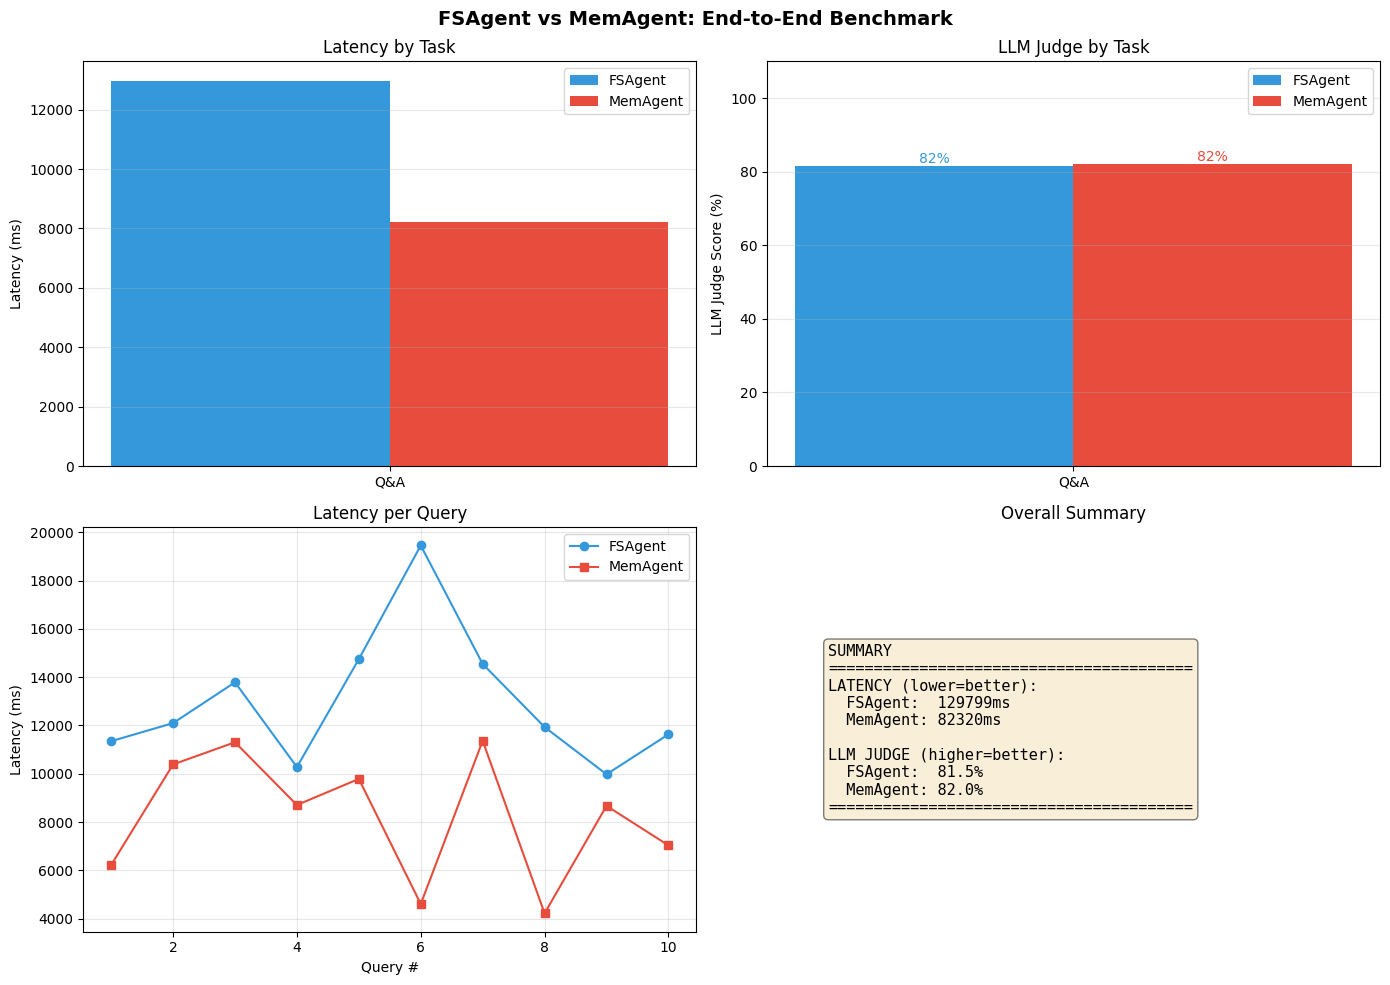

[OK] Chart saved


In [54]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("FSAgent vs MemAgent: End-to-End Benchmark", fontsize=14, fontweight='bold')
FS_COLOR, DB_COLOR = "#3498db", "#e74c3c"

# 1. Latency by Task
ax1 = axes[0, 0]
x = np.arange(len(tasks))
width = 0.35
fs_lat = [statistics.mean(fs_latencies_by_task[t]) if fs_latencies_by_task[t] else 0 for t in tasks]
db_lat = [statistics.mean(db_latencies_by_task[t]) if db_latencies_by_task[t] else 0 for t in tasks]
bars1 = ax1.bar(x - width/2, fs_lat, width, label='FSAgent', color=FS_COLOR)
bars2 = ax1.bar(x + width/2, db_lat, width, label='MemAgent', color=DB_COLOR)
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Latency by Task')
ax1.set_xticks(x)
ax1.set_xticklabels(task_labels)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. LLM Judge by Task (with value labels)
ax2 = axes[0, 1]
fs_llm_task = {t: [] for t in tasks}
db_llm_task = {t: [] for t in tasks}
if 'llm_judge_results' in dir():
    for r in llm_judge_results:
        if r["task"] not in tasks: continue
        if r["agent"] == "fs": fs_llm_task[r["task"]].append(r["score"])
        else: db_llm_task[r["task"]].append(r["score"])
fs_llm_means = [statistics.mean(fs_llm_task[t]) if fs_llm_task[t] else 0 for t in tasks]
db_llm_means = [statistics.mean(db_llm_task[t]) if db_llm_task[t] else 0 for t in tasks]
bars1 = ax2.bar(x - width/2, fs_llm_means, width, label='FSAgent', color=FS_COLOR)
bars2 = ax2.bar(x + width/2, db_llm_means, width, label='MemAgent', color=DB_COLOR)
# Add value labels
for bar, val in zip(bars1, fs_llm_means):
    ax2.annotate(f'{val:.0f}%', xy=(bar.get_x() + bar.get_width()/2, max(val, 5)),
                 ha='center', va='bottom', fontsize=10, color=FS_COLOR)
for bar, val in zip(bars2, db_llm_means):
    ax2.annotate(f'{val:.0f}%', xy=(bar.get_x() + bar.get_width()/2, max(val, 5)),
                 ha='center', va='bottom', fontsize=10, color=DB_COLOR)
ax2.set_ylabel('LLM Judge Score (%)')
ax2.set_title('LLM Judge by Task')
ax2.set_xticks(x)
ax2.set_xticklabels(task_labels)
ax2.set_ylim(0, 110)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Latency Timeline
ax3 = axes[1, 0]
fs_filtered = [r for r in fs_results if r.task in tasks]
db_filtered = [r for r in db_results if r.task in tasks]
if fs_filtered:
    ax3.plot(range(1, len(fs_filtered)+1), [r.latency_ms for r in fs_filtered], 'o-', color=FS_COLOR, label='FSAgent')
if db_filtered:
    ax3.plot(range(1, len(db_filtered)+1), [r.latency_ms for r in db_filtered], 's-', color=DB_COLOR, label='MemAgent')
ax3.set_xlabel('Query #')
ax3.set_ylabel('Latency (ms)')
ax3.set_title('Latency per Query')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Overall Summary
ax4 = axes[1, 1]
ax4.axis('off')
fs_llm = statistics.mean([r['score'] for r in llm_judge_results if r['agent']=='fs']) if 'llm_judge_results' in dir() and llm_judge_results else 0
db_llm = statistics.mean([r['score'] for r in llm_judge_results if r['agent']=='db']) if 'llm_judge_results' in dir() and llm_judge_results else 0
summary = f'''SUMMARY
{'='*40}
LATENCY (lower=better):
  FSAgent:  {fs_total_latency:.0f}ms
  MemAgent: {db_total_latency:.0f}ms

LLM JUDGE (higher=better):
  FSAgent:  {fs_llm:.1f}%
  MemAgent: {db_llm:.1f}%
{'='*40}'''
ax4.text(0.1, 0.5, summary, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.set_title('Overall Summary')

plt.tight_layout()
plt.savefig('agent_benchmark_results.png', dpi=150)
plt.show()
print("[OK] Chart saved")

## 3.8 Conclusions

In [ ]:
# Final Conclusions with LLM Judge
print("=" * 70)
print("BENCHMARK CONCLUSIONS")
print("=" * 70)

latency_winner = "FSAgent" if fs_total_latency < db_total_latency else "MemAgent"
llm_winner = "FSAgent" if fs_avg_llm > db_avg_llm else "MemAgent"
fs_wins = [latency_winner, llm_winner].count("FSAgent")
overall = "FSAgent" if fs_wins >= 1 else "MemAgent"

print(f"""
RESULTS SUMMARY
{'='*60}
LATENCY:        FSAgent={fs_total_latency:.0f}ms | MemAgent={db_total_latency:.0f}ms -> {latency_winner} (fast)
LLM JUDGE:      FSAgent={fs_avg_llm:.1f}% | MemAgent={db_avg_llm:.1f}% -> {llm_winner} [LLM Judge]
{'='*60}
OVERALL WINNER: {overall} (won {max(fs_wins, 2-fs_wins)}/2 categories)

RECOMMENDATIONS:
• FSAgent: Fast prototyping, simple search, local single-user
• MemAgent: Semantic search, production use, better response quality
""")

## 3.9 Large Corpus Benchmark: Concatenated vs Chunked

This benchmark tests how each agent handles a large corpus of research papers. We compare two approaches:

- **FSAgent**: All 10 papers concatenated into a single large markdown file. The agent must use `grep_files` and `read_file_range` to find relevant sections.
- **MemAgent**: Papers chunked and embedded into the vector store. The agent uses semantic similarity search to retrieve relevant chunks.

This tests the trade-off between keyword-based search over large files vs. semantic search over chunked embeddings.

In [ ]:
# 3.9.1 Prepare Large Corpus from ArXiv Papers (Full PDF Content)
import time
from pathlib import Path
from langchain_community.document_loaders import ArxivLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 10 valid papers from the curated list (all confirmed to exist)
CORPUS_ARXIV_IDS = [
    "2310.08560",  # MemGPT: Towards LLMs as Operating Systems
    "2303.11366",  # Reflexion: Language Agents with Verbal Reinforcement Learning
    "2304.03442",  # Generative Agents: Interactive Simulacra of Human Behavior
    "2404.13501",  # A Survey on the Memory Mechanism of LLM-Based Agents
    "2410.10813",  # LongMemEval: Benchmarking Chat Assistants on Long-Term Memory
    "2402.17753",  # LoCoMo: Evaluating Very Long-Term Conversational Memory
    "2404.02039",  # A Survey on Large Language Model-Based Game Agents
    "2411.08432",  # One STEP at a time: Language Agents are Stepwise Planners
    "2309.02427",  # Cognitive Architectures for Language Agents (CoALA)
    "2308.11432",  # AgentBench: Evaluating LLMs as Agents
    "2505.16067",  # How Memory Management Impacts LLM Agents: An Empirical Study of Experience-Following Behavior
    "2504.19413",  # Mem0: Building Production-Ready AI Agents with Scalable Long-Term Memory   
]

# Fetch FULL papers (PDF -> text, not just abstracts)
print("=" * 70)
print("FETCHING FULL PAPERS FOR LARGE CORPUS BENCHMARK")
print("=" * 70)
print("Note: Each paper downloads PDF and extracts text (~30-80K chars each)")
print()

corpus_papers = []

for arxiv_id in CORPUS_ARXIV_IDS:
    try:
        print(f"[FETCH] {arxiv_id}...", end=" ", flush=True)
        
        # Use ArxivLoader with explicit settings to get full PDF content
        loader = ArxivLoader(
            query=arxiv_id,
            load_max_docs=1,
            load_all_available_meta=True,
        )
        docs = loader.load()
        
        if docs:
            content = docs[0].page_content
            char_count = len(content)
            
            # Check if we got full content (abstracts are typically <3000 chars)
            if char_count > 5000:
                corpus_papers.append({
                    "id": arxiv_id,
                    "title": docs[0].metadata.get("Title", arxiv_id),
                    "content": content
                })
                print(f"[OK] {char_count:,} chars (full paper)")
            else:
                print(f"[WARN] Only {char_count:,} chars - may be abstract only")
                # Still add it but warn
                corpus_papers.append({
                    "id": arxiv_id,
                    "title": docs[0].metadata.get("Title", arxiv_id),
                    "content": content
                })
        else:
            print("[SKIP] No documents returned")
            
        time.sleep(3)  # Rate limiting for PDF downloads
        
    except Exception as e:
        print(f"[ERROR] {str(e)[:60]}")

total_chars = sum(len(p["content"]) for p in corpus_papers)
print(f"\n{'=' * 70}")
print(f"Fetched {len(corpus_papers)} papers")
print(f"Total corpus size: {total_chars:,} characters ({total_chars // 1000}K)")
if corpus_papers:
    print(f"Average paper size: {total_chars // len(corpus_papers):,} chars")
    if total_chars // len(corpus_papers) < 10000:
        print("[WARN] Average size is low - may only have abstracts. Check pymupdf installation.")

In [57]:
# 3.9.2 Prepare Corpus for Both Agents

# === FSAgent: Concatenate all papers into one large markdown file ===
corpus_dir = Path("semantic/knowledge_base")
corpus_dir.mkdir(parents=True, exist_ok=True)
corpus_file = corpus_dir / "agent_memory_corpus.md"

concatenated_content = []
for paper in corpus_papers:
    concatenated_content.append(f"""
{'='*80}
# {paper['title']}
ArXiv ID: {paper['id']}
{'='*80}

{paper['content']}
""")

corpus_file.write_text("\n\n".join(concatenated_content), encoding="utf-8")
total_chars = len(corpus_file.read_text())
print(f"[FS] Created concatenated corpus: {corpus_file}")
print(f"[FS] Total size: {total_chars:,} characters ({total_chars // 1000}K)")

# === MemAgent: Chunk and embed into vector store ===
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    separators=["\n\n", "\n", ". ", " ", ""]
)

all_chunks = []
all_metadatas = []

for paper in corpus_papers:
    chunks = text_splitter.split_text(paper['content'])
    for i, chunk in enumerate(chunks):
        all_chunks.append(chunk)
        all_metadatas.append({
            "arxiv_id": paper['id'],
            "title": paper['title'],
            "chunk_index": i,
            "source": "corpus_benchmark"
        })

print(f"\n[DB] Total chunks to embed: {len(all_chunks)}")
print(f"[DB] Adding to vector store...", end=" ")

# Add to knowledge base vector store
knowledge_base_vs.add_texts(all_chunks, all_metadatas)
print("[OK]")

print(f"\nCorpus prepared for both agents:")
print(f"  - FSAgent: 1 file with {len(corpus_papers)} papers ({total_chars:,} chars)")
print(f"  - MemAgent: {len(all_chunks)} chunks in vector store")

[FS] Created concatenated corpus: semantic/knowledge_base/agent_memory_corpus.md
[FS] Total size: 1,201,752 characters (1201K)

[DB] Total chunks to embed: 928
[DB] Adding to vector store... [OK]

Corpus prepared for both agents:
  - FSAgent: 1 file with 12 papers (1,201,752 chars)
  - MemAgent: 928 chunks in vector store


In [58]:
# 3.9.3 Define Corpus Benchmark Queries

CORPUS_QUERIES = [
    "What is MemGPT and how does it manage context like an operating system?",
    "Explain the Reflexion framework and how verbal reinforcement learning works.",
    "How do generative agents simulate human behavior in sandbox environments?",
    "What are the different types of memory in LLM-based agents according to surveys?",
    "How is long-term conversational memory evaluated in benchmarks like LongMemEval?",
    "What techniques are used for memory compression in conversational agents?",
    "How do game-playing agents use memory to improve performance?",
    "What is stepwise planning and how does it relate to agent memory?",
    "Compare episodic and semantic memory in the context of LLM agents.",
    "What are the main challenges in building agents with persistent memory?",

    # Added from the provided corpus (capability acquisition + applications)
    "What are the trade-offs between fine-tuning and prompting/mechanism engineering for improving LLM-agent capabilities?",
    "Why is fine-tuning often only suitable for open-source LLMs, and what alternatives exist for closed-source models?",
    "How do LLM context window limitations constrain non–fine-tuned agent capability acquisition methods?",
    "What practical methods can teams use to search the large design space of prompts and agent mechanisms?",
    "In CLMTWA, how does a teacher LLM use theory of mind to generate explanations that improve a student model’s reasoning?",
    "What does it mean to personalize explanations for a student model, and what signals indicate personalization is needed?",
    "How can 'expected utility of intervention' be operationalized to decide when a teacher agent should intervene?",
    "What failure modes occur if a teacher agent intervenes too frequently or too rarely?",
    "In NLSOM-style systems, how do agents collaborate in natural language to solve problems beyond a single agent’s scope?",
    "What feedback signals should trigger dynamic adjustment of roles, tasks, and relationships in multi-agent collaboration?",
    "Operationally, what does an inter-agent 'relationship' represent (authority, trust, specialization, dependencies), and why does it matter?",
    "What risks arise from dynamic role assignment in multi-agent systems (oscillation, coordination overhead, accountability issues)?",
    "How would you compare teacher–student orchestration (CLMTWA) vs peer collaboration (NLSOM) in terms of reliability and scalability?",

    # Social science applications
    "Why are LLM-based agents useful for psychology simulation experiments, and what are the limitations compared to human studies?",
    "What is 'hyper-accuracy distortion' in psychology simulations, and how can it bias downstream applications?",
    "How would you design an evaluation to detect hyper-accuracy distortion in an LLM agent running psychology tasks?",
    "What are the benefits and risks of LLM conversation agents for mental well-being support, and what guardrails are required?",
    "In political science/economy applications (ideology detection, voting prediction, persuasion analysis), what are key ethical and methodological risks?",

    # Social simulation
    "Why are some social experiments expensive, unethical, or infeasible with humans, and how do LLM-based simulations change that?",
    "In multi-agent social simulations (e.g., virtual towns), what memory and identity mechanisms are needed for believable long-term behavior?",
    "Which social phenomena are easiest vs hardest to simulate with LLM agents (misinformation spread, emotion contagion, norm formation), and why?",
    "How would you validate that an LLM-agent social simulation reflects meaningful dynamics rather than prompt artifacts?",

    # Jurisprudence
    "How does a multi-judge voting mechanism (e.g., Blind Judgement) reduce decision risk, and what new risks can it introduce?",
    "How do database + keyword search strategies (e.g., ChatLaw) mitigate hallucination in legal agents, and what failure modes remain?",
    "What are 'reference inaccuracies' in legal reasoning, and why are they especially dangerous for LLM-based agents?",

    # Natural science: documentation + experiments
    "Why are documentation and data management tasks well-suited for tool-using LLM agents that query the internet and databases?",
    "What’s the difference between agents focused on information extraction (e.g., ChatMOF) versus agents that plan and execute workflows (e.g., experiment assistants)?",
    "How do safety-oriented chemistry tools (e.g., identifying dangerous substances) change the risk profile of LLM scientific assistants?",
    "What are the risks of agents that autonomously design and execute experiments, and how should sandboxing and permissions be enforced?",

    # Education agents
    "What capabilities make LLM-based education agents effective (personalization, explanation, feedback), and where do they fail?",
    "How can an education agent monitor student queries responsibly while preserving privacy and avoiding surveillance creep?",
    "What is the difference between an agent that can solve math problems and one that can teach mathematical reasoning effectively?",
    "How would you evaluate whether an education agent improves critical thinking rather than just answer correctness?",

    # Engineering: software engineering + analysis
    "What advantages do multi-role software engineering agent frameworks (e.g., ChatDev, MetaGPT) have over a single coding agent?",
    "How does self-collaboration among multiple LLM 'experts' affect code quality, cost, and reliability compared to single-agent generation?",
    "How does tree-of-thought with backtracking (e.g., D-Bot) improve diagnostic accuracy in debugging and anomaly analysis?",
]


print(f"Defined {len(CORPUS_QUERIES)} corpus benchmark queries")

Defined 46 corpus benchmark queries


In [ ]:
# 3.9.4 Run Corpus Benchmark
import time

corpus_results = {"fsagent": [], "memagent": []}

print("=" * 70)
print("CORPUS BENCHMARK: FSAgent (grep) vs MemAgent (vector search)")
print("=" * 70)

for i, query in enumerate(CORPUS_QUERIES, 1):
    print(f"\n[Query {i}/{len(CORPUS_QUERIES)}] {query[:60]}...")
    
    # === FSAgent ===
    print("  [FS] Running FSAgent...", end=" ")
    fs_start = time.time()
    try:
        fs_response = fs_agent.invoke(
            {"messages": [{"role": "user", "content": f"Using the agent_memory_corpus.md file, answer: {query}"}]}
        )
        fs_answer = fs_response["messages"][-1].content if fs_response.get("messages") else ""
        fs_latency = time.time() - fs_start
        print(f"[OK] {fs_latency:.2f}s")
    except Exception as e:
        fs_answer = f"Error: {e}"
        fs_latency = time.time() - fs_start
        print(f"[ERROR] {e}")
    
    corpus_results["fsagent"].append({
        "query": query,
        "response": fs_answer,
        "latency": fs_latency
    })
    
    # === MemAgent ===
    print("  [DB] Running MemAgent...", end=" ")
    mem_start = time.time()
    try:
        mem_response = MEM_AGENT.invoke(
            {"messages": [{"role": "user", "content": query}]}
        )
        mem_answer = mem_response["messages"][-1].content if mem_response.get("messages") else ""
        mem_latency = time.time() - mem_start
        print(f"[OK] {mem_latency:.2f}s")
    except Exception as e:
        mem_answer = f"Error: {e}"
        mem_latency = time.time() - mem_start
        print(f"[ERROR] {e}")
    
    corpus_results["memagent"].append({
        "query": query,
        "response": mem_answer,
        "latency": mem_latency
    })

print("\n" + "=" * 70)
print("CORPUS BENCHMARK COMPLETE")
print("=" * 70)

In [60]:
# 3.9.5 Corpus Benchmark Analysis

import statistics

# Calculate latency statistics
fs_latencies = [r["latency"] for r in corpus_results["fsagent"]]
mem_latencies = [r["latency"] for r in corpus_results["memagent"]]

print("=" * 70)
print("CORPUS BENCHMARK RESULTS")
print("=" * 70)

print("\n## Latency Comparison")
print(f"{'Metric':<20} {'FSAgent':<15} {'MemAgent':<15}")
print("-" * 50)
print(f"{'Mean Latency':<20} {statistics.mean(fs_latencies):.2f}s{'':<10} {statistics.mean(mem_latencies):.2f}s")
print(f"{'Median Latency':<20} {statistics.median(fs_latencies):.2f}s{'':<10} {statistics.median(mem_latencies):.2f}s")
print(f"{'Min Latency':<20} {min(fs_latencies):.2f}s{'':<10} {min(mem_latencies):.2f}s")
print(f"{'Max Latency':<20} {max(fs_latencies):.2f}s{'':<10} {max(mem_latencies):.2f}s")

# Calculate response lengths
fs_lengths = [len(r["response"]) for r in corpus_results["fsagent"]]
mem_lengths = [len(r["response"]) for r in corpus_results["memagent"]]

print("\n## Response Length Comparison")
print(f"{'Metric':<20} {'FSAgent':<15} {'MemAgent':<15}")
print("-" * 50)
print(f"{'Mean Length':<20} {statistics.mean(fs_lengths):.0f} chars{'':<5} {statistics.mean(mem_lengths):.0f} chars")
print(f"{'Total Chars':<20} {sum(fs_lengths):,}{'':<10} {sum(mem_lengths):,}")

# Winner summary
fs_wins = sum(1 for f, m in zip(fs_latencies, mem_latencies) if f < m)
mem_wins = len(fs_latencies) - fs_wins

print("\n## Per-Query Winners (by latency)")
print(f"  FSAgent faster: {fs_wins}/{len(CORPUS_QUERIES)} queries")
print(f"  MemAgent faster: {mem_wins}/{len(CORPUS_QUERIES)} queries")

CORPUS BENCHMARK RESULTS

## Latency Comparison
Metric               FSAgent         MemAgent       
--------------------------------------------------
Mean Latency         5.85s           34.24s
Median Latency       4.85s           10.20s
Min Latency          3.59s           3.07s
Max Latency          15.76s           1032.60s

## Response Length Comparison
Metric               FSAgent         MemAgent       
--------------------------------------------------
Mean Length          542 chars      2474 chars
Total Chars          24,918           113,803

## Per-Query Winners (by latency)
  FSAgent faster: 40/46 queries
  MemAgent faster: 6/46 queries


In [ ]:
# 3.9.6 LLM-as-Judge for Corpus Benchmark
print("=" * 70)
print("LLM-AS-JUDGE: CORPUS BENCHMARK")
print("=" * 70)

corpus_llm_scores = {"fsagent": [], "memagent": []}

print("\n[LLM Judge] Evaluating FSAgent responses...")
for i, r in enumerate(corpus_results["fsagent"]):
    print(f"  [{i+1}/{len(corpus_results['fsagent'])}] {r['query'][:50]}...", end=" ")
    j = llm_judge_response(r["query"], r["response"])
    corpus_llm_scores["fsagent"].append(j["score"])
    print(f"Score: {j['score']:.0f}%")

print("\n[LLM Judge] Evaluating MemAgent responses...")
for i, r in enumerate(corpus_results["memagent"]):
    print(f"  [{i+1}/{len(corpus_results['memagent'])}] {r['query'][:50]}...", end=" ")
    j = llm_judge_response(r["query"], r["response"])
    corpus_llm_scores["memagent"].append(j["score"])
    print(f"Score: {j['score']:.0f}%")

fs_avg_corpus = statistics.mean(corpus_llm_scores["fsagent"]) if corpus_llm_scores["fsagent"] else 0
mem_avg_corpus = statistics.mean(corpus_llm_scores["memagent"]) if corpus_llm_scores["memagent"] else 0

print(f"\n{'=' * 70}")
print(f"CORPUS LLM JUDGE SUMMARY")
print(f"{'=' * 70}")
print(f"FSAgent Average:  {fs_avg_corpus:.1f}%")
print(f"MemAgent Average: {mem_avg_corpus:.1f}%")
print(f"Winner: {'FSAgent' if fs_avg_corpus > mem_avg_corpus else 'MemAgent'}")

/var/folders/8r/qvgk1jk97zdc9z1jjtdhm_440000gn/T/ipykernel_76924/1074112835.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([fs_latencies, mem_latencies], labels=['FSAgent', 'MemAgent'], patch_artist=True)


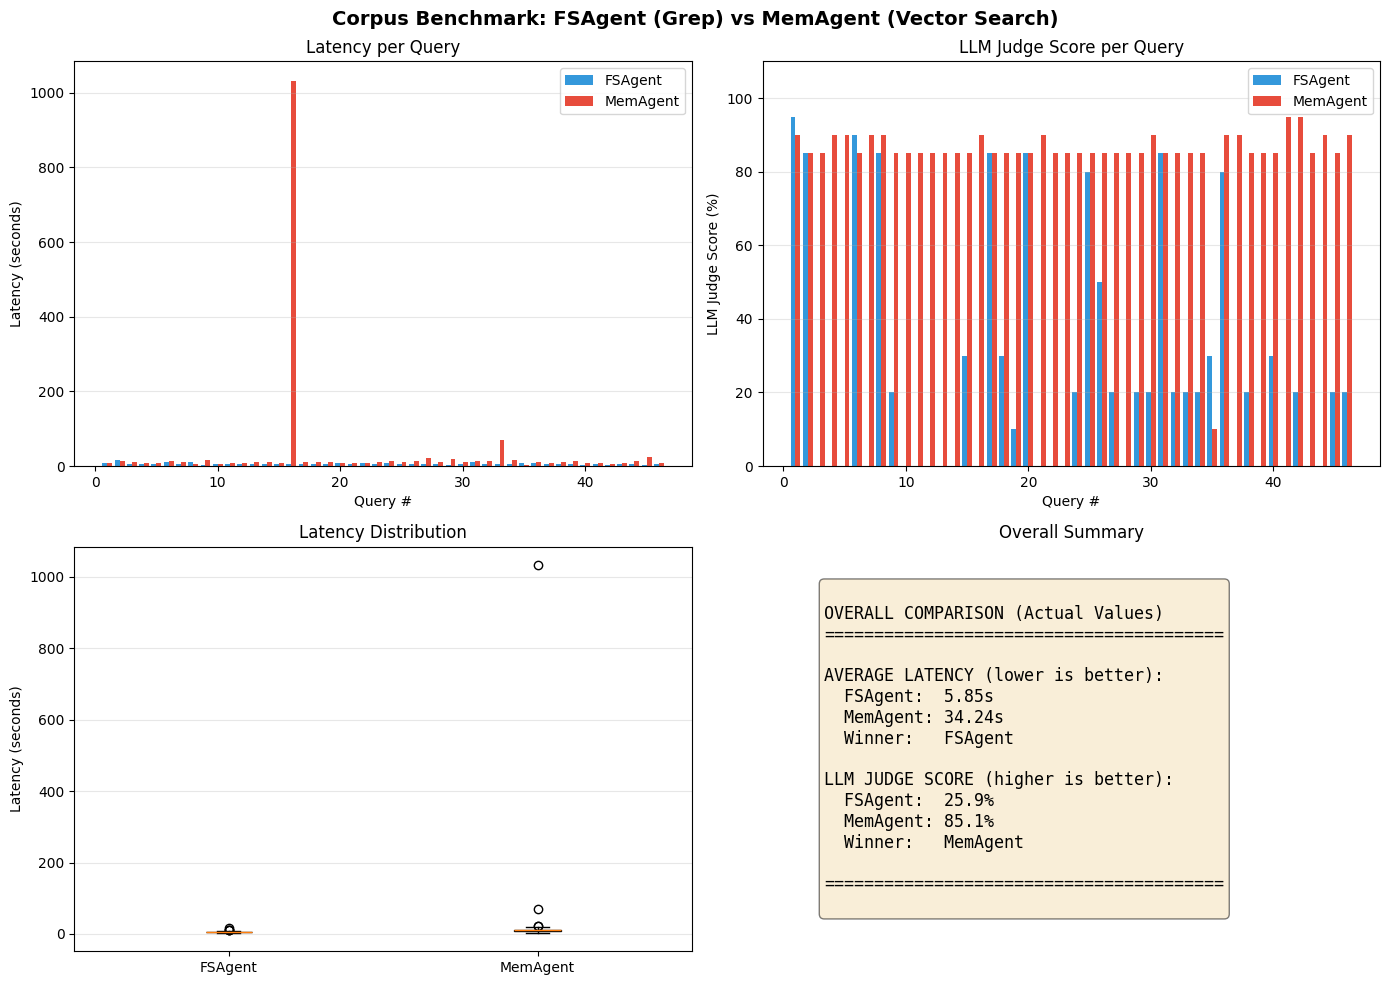


[OK] Saved: corpus_benchmark_results.png


In [62]:
# 3.9.7 Corpus Benchmark Visualization
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Corpus Benchmark: FSAgent (Grep) vs MemAgent (Vector Search)", fontsize=14, fontweight='bold')

FS_COLOR, MEM_COLOR = "#3498db", "#e74c3c"

# 1. Latency per Query
ax1 = axes[0, 0]
query_nums = range(1, len(CORPUS_QUERIES) + 1)
ax1.bar([x - 0.2 for x in query_nums], fs_latencies, 0.4, label='FSAgent', color=FS_COLOR)
ax1.bar([x + 0.2 for x in query_nums], mem_latencies, 0.4, label='MemAgent', color=MEM_COLOR)
ax1.set_xlabel('Query #')
ax1.set_ylabel('Latency (seconds)')
ax1.set_title('Latency per Query')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. LLM Judge Scores per Query
ax2 = axes[0, 1]
ax2.bar([x - 0.2 for x in query_nums], corpus_llm_scores["fsagent"], 0.4, label='FSAgent', color=FS_COLOR)
ax2.bar([x + 0.2 for x in query_nums], corpus_llm_scores["memagent"], 0.4, label='MemAgent', color=MEM_COLOR)
ax2.set_xlabel('Query #')
ax2.set_ylabel('LLM Judge Score (%)')
ax2.set_title('LLM Judge Score per Query')
ax2.set_ylim(0, 110)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Latency Comparison (Box Plot)
ax3 = axes[1, 0]
bp = ax3.boxplot([fs_latencies, mem_latencies], labels=['FSAgent', 'MemAgent'], patch_artist=True)
bp['boxes'][0].set_facecolor(FS_COLOR)
bp['boxes'][1].set_facecolor(MEM_COLOR)
ax3.set_ylabel('Latency (seconds)')
ax3.set_title('Latency Distribution')
ax3.grid(axis='y', alpha=0.3)

# 4. Overall Summary - Show actual values
ax4 = axes[1, 1]
ax4.axis('off')  # Turn off axis for text-based summary

fs_avg_lat = statistics.mean(fs_latencies)
mem_avg_lat = statistics.mean(mem_latencies)
latency_winner = 'FSAgent' if fs_avg_lat < mem_avg_lat else 'MemAgent'
llm_winner = 'FSAgent' if fs_avg_corpus > mem_avg_corpus else 'MemAgent'

summary_text = f"""
OVERALL COMPARISON (Actual Values)
{'='*40}

AVERAGE LATENCY (lower is better):
  FSAgent:  {fs_avg_lat:.2f}s
  MemAgent: {mem_avg_lat:.2f}s
  Winner:   {latency_winner}

LLM JUDGE SCORE (higher is better):
  FSAgent:  {fs_avg_corpus:.1f}%
  MemAgent: {mem_avg_corpus:.1f}%
  Winner:   {llm_winner}

{'='*40}
"""

ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax4.set_title('Overall Summary')

plt.tight_layout()
plt.savefig("corpus_benchmark_results.png", dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Saved: corpus_benchmark_results.png")

> 💡 **Key Takeaways**
> - **Large corpus handling**: FSAgent requires multiple grep/read operations; MemAgent retrieves directly via vector similarity
> - **Latency trade-off**: FSAgent may be slower on large files due to sequential search; MemAgent benefits from indexed retrieval
> - **Response quality**: LLM Judge scores reveal which approach produces more relevant, comprehensive answers
> - **Scalability**: Chunked embeddings scale better for growing corpora; concatenated files hit practical limits

# Part 4: ACID Transactions & Concurrency

----

A critical difference between filesystem and database storage that's often overlooked: **how they handle concurrent access**.

When multiple processes or threads try to write to the same resource simultaneously:

| Property | Filesystem | Database (ACID) |
|----------|------------|------------------|
| **Atomicity** | No - partial writes can corrupt files | Yes - all or nothing |
| **Consistency** | No constraint enforcement | Yes - constraints, foreign keys |
| **Isolation** | No - concurrent reads see incomplete writes | Yes - transaction isolation |
| **Durability** | Depends on fsync | Yes - WAL, redo logs |

This matters for agents because:
- Multiple users might query the same knowledge base
- Background processes might be indexing while users are querying
- A crash during write could corrupt the memory store

Let's demonstrate this with a practical test.

## 4.1 Concurrency Test Setup

We'll simulate multiple concurrent writers trying to append entries to:
1. A shared file (FSAgent pattern)
2. A database table (MemAgent pattern)

Each writer will append 50 entries. With 10 concurrent writers, we expect **500 total entries** if everything works correctly.

In [63]:
# Concurrency Test Configuration
import threading
import time
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

NUM_WRITERS = 10       # Number of concurrent threads
WRITES_PER_THREAD = 50 # Entries each thread writes
EXPECTED_TOTAL = NUM_WRITERS * WRITES_PER_THREAD  # 500

# Test file path (reuses episodic directory from FSAgent)
CONCURRENCY_TEST_FILE = Path("episodic") / "concurrency_test.md"

# Test table (reuses database_connection from MemAgent)
CONCURRENCY_TEST_TABLE = "CONCURRENCY_TEST"

print(f"[OK] Test configured: {NUM_WRITERS} writers × {WRITES_PER_THREAD} writes = {EXPECTED_TOTAL} expected entries")

[OK] Test configured: 10 writers × 50 writes = 500 expected entries


## 4.2 Filesystem Concurrency Test (Naive - No Locking)

Multiple threads will append to the same file simultaneously using a **read-modify-write** pattern without any locking. This is a common anti-pattern known as [TOCTOU (Time-of-check to time-of-use)](https://en.wikipedia.org/wiki/Time-of-check_to_time-of-use) that causes **race conditions**:

- Lost writes (one thread's write overwrites another's)
- Corrupted content (interleaved partial writes)
- Missing entries

> **Note:** This demonstrates what happens when filesystem code is written naively. We'll show a properly locked version next.

In [64]:
def file_writer(writer_id: int, num_writes: int, filepath: Path) -> int:
    """
    Simulate FSAgent-style file append without locking.
    Returns the number of writes attempted.
    """
    for i in range(num_writes):
        entry = f"[Writer-{writer_id}] Entry {i+1} @ {_ts_utc()}\n"
        
        # FSAgent pattern: read existing + append + write back
        # This is NOT atomic and creates a race condition
        try:
            existing = filepath.read_text() if filepath.exists() else ""
            filepath.write_text(existing + entry)
        except Exception as e:
            pass  # Silently fail (simulates real-world issues)
    
    return num_writes


def run_file_concurrency_test() -> dict:
    """Run concurrent file writers and count results."""
    
    # Clean start
    if CONCURRENCY_TEST_FILE.exists():
        CONCURRENCY_TEST_FILE.unlink()
    CONCURRENCY_TEST_FILE.parent.mkdir(parents=True, exist_ok=True)
    CONCURRENCY_TEST_FILE.write_text("# Concurrency Test\n\n")
    
    print(f"Starting {NUM_WRITERS} concurrent file writers...")
    start_time = time.perf_counter()
    
    # Launch concurrent writers
    with ThreadPoolExecutor(max_workers=NUM_WRITERS) as executor:
        futures = [
            executor.submit(file_writer, i, WRITES_PER_THREAD, CONCURRENCY_TEST_FILE)
            for i in range(NUM_WRITERS)
        ]
        for f in as_completed(futures):
            f.result()  # Wait for all to complete
    
    elapsed = time.perf_counter() - start_time
    
    # Count actual entries written
    content = CONCURRENCY_TEST_FILE.read_text()
    actual_entries = content.count("[Writer-")
    
    # Count entries per writer
    writer_counts = {}
    for i in range(NUM_WRITERS):
        writer_counts[f"Writer-{i}"] = content.count(f"[Writer-{i}]")
    
    return {
        "expected": EXPECTED_TOTAL,
        "actual": actual_entries,
        "lost": EXPECTED_TOTAL - actual_entries,
        "loss_rate": (EXPECTED_TOTAL - actual_entries) / EXPECTED_TOTAL * 100,
        "elapsed_ms": elapsed * 1000,
        "writer_counts": writer_counts,
    }

print("[OK] File concurrency test ready")

[OK] File concurrency test ready


In [65]:
# Run Filesystem Concurrency Test
print("=" * 60)
print("FILESYSTEM CONCURRENCY TEST (No Locking)")
print("=" * 60)

file_results = run_file_concurrency_test()

print(f"\nResults:")
print(f"  Expected entries: {file_results['expected']}")
print(f"  Actual entries:   {file_results['actual']}")
print(f"  Lost entries:     {file_results['lost']} ({file_results['loss_rate']:.1f}% loss)")
print(f"  Time elapsed:     {file_results['elapsed_ms']:.0f}ms")

print(f"\nEntries per writer:")
for writer, count in file_results['writer_counts'].items():
    expected = WRITES_PER_THREAD
    status = '[OK]' if count == expected else f'[LOST {expected - count}]'
    print(f"  {writer}: {count}/{expected} {status}")

if file_results['lost'] > 0:
    print(f"\n[WARNING] Race condition detected! {file_results['lost']} writes were lost.")
else:
    print(f"\n[OK] No data loss (may vary between runs)")

FILESYSTEM CONCURRENCY TEST (No Locking)
Starting 10 concurrent file writers...

Results:
  Expected entries: 500
  Actual entries:   14
  Lost entries:     486 (97.2% loss)
  Time elapsed:     33ms

Entries per writer:
  Writer-0: 1/50 [LOST 49]
  Writer-1: 2/50 [LOST 48]
  Writer-2: 1/50 [LOST 49]
  Writer-3: 0/50 [LOST 50]
  Writer-4: 1/50 [LOST 49]
  Writer-5: 1/50 [LOST 49]
  Writer-6: 3/50 [LOST 47]
  Writer-7: 3/50 [LOST 47]
  Writer-8: 0/50 [LOST 50]
  Writer-9: 2/50 [LOST 48]

[WARNING] Race condition detected! 486 writes were lost.


## 4.2b Filesystem Concurrency Test (With Locking)

Now let's run the same test but with **proper file locking** using `fcntl.flock()`. This demonstrates that filesystems CAN handle concurrency safely when implemented correctly:

- **Exclusive lock (LOCK_EX)** ensures only one writer at a time
- **Append mode** is more atomic than read-modify-write
- Trade-off: Slower due to lock contention, but guarantees data integrity

> **Note:** `flock()` works on local filesystems but has limitations on NFS and network shares.

In [66]:
import fcntl

# Test file for locked writes
CONCURRENCY_TEST_FILE_LOCKED = Path("episodic") / "concurrency_test_locked.md"

def file_writer_with_lock(writer_id: int, num_writes: int, filepath: Path) -> int:
    """
    Filesystem append with proper locking using fcntl.flock().
    This is the CORRECT way to handle concurrent file writes.
    """
    for i in range(num_writes):
        entry = f"[Writer-{writer_id}] Entry {i+1} @ {_ts_utc()}\n"
        
        # Proper pattern: open in append mode with exclusive lock
        with open(filepath, 'a') as f:
            fcntl.flock(f.fileno(), fcntl.LOCK_EX)  # Acquire exclusive lock
            f.write(entry)
            f.flush()  # Ensure write is complete
            fcntl.flock(f.fileno(), fcntl.LOCK_UN)  # Release lock
    
    return num_writes


def run_file_concurrency_test_locked() -> dict:
    """Run concurrent file writers WITH locking and count results."""
    
    # Clean start
    if CONCURRENCY_TEST_FILE_LOCKED.exists():
        CONCURRENCY_TEST_FILE_LOCKED.unlink()
    CONCURRENCY_TEST_FILE_LOCKED.parent.mkdir(parents=True, exist_ok=True)
    CONCURRENCY_TEST_FILE_LOCKED.write_text("# Concurrency Test (Locked)\n\n")
    
    print(f"Starting {NUM_WRITERS} concurrent file writers WITH locking...")
    start_time = time.perf_counter()
    
    # Launch concurrent writers
    with ThreadPoolExecutor(max_workers=NUM_WRITERS) as executor:
        futures = [
            executor.submit(file_writer_with_lock, i, WRITES_PER_THREAD, CONCURRENCY_TEST_FILE_LOCKED)
            for i in range(NUM_WRITERS)
        ]
        for f in as_completed(futures):
            f.result()
    
    elapsed = time.perf_counter() - start_time
    
    # Count actual entries written
    content = CONCURRENCY_TEST_FILE_LOCKED.read_text()
    actual_entries = content.count("[Writer-")
    
    # Count entries per writer
    writer_counts = {}
    for i in range(NUM_WRITERS):
        writer_counts[f"Writer-{i}"] = content.count(f"[Writer-{i}]")
    
    return {
        "expected": EXPECTED_TOTAL,
        "actual": actual_entries,
        "lost": EXPECTED_TOTAL - actual_entries,
        "loss_rate": (EXPECTED_TOTAL - actual_entries) / EXPECTED_TOTAL * 100,
        "elapsed_ms": elapsed * 1000,
        "writer_counts": writer_counts,
    }

print("[OK] Locked file concurrency test ready")

[OK] Locked file concurrency test ready


In [67]:
# Run Locked Filesystem Concurrency Test
print("=" * 60)
print("FILESYSTEM CONCURRENCY TEST (With flock Locking)")
print("=" * 60)

file_locked_results = run_file_concurrency_test_locked()

print(f"\nResults:")
print(f"  Expected entries: {file_locked_results['expected']}")
print(f"  Actual entries:   {file_locked_results['actual']}")
print(f"  Lost entries:     {file_locked_results['lost']} ({file_locked_results['loss_rate']:.1f}% loss)")
print(f"  Time elapsed:     {file_locked_results['elapsed_ms']:.0f}ms")

print(f"\nEntries per writer:")
for writer, count in file_locked_results['writer_counts'].items():
    expected = WRITES_PER_THREAD
    status = '[OK]' if count == expected else f'[LOST {expected - count}]'
    print(f"  {writer}: {count}/{expected} {status}")

if file_locked_results['lost'] > 0:
    print(f"\n[WARNING] Data loss detected: {file_locked_results['lost']} writes were lost.")
else:
    print(f"\n[OK] Zero data loss - File locking ensures consistency!")

FILESYSTEM CONCURRENCY TEST (With flock Locking)
Starting 10 concurrent file writers WITH locking...

Results:
  Expected entries: 500
  Actual entries:   500
  Lost entries:     0 (0.0% loss)
  Time elapsed:     15ms

Entries per writer:
  Writer-0: 50/50 [OK]
  Writer-1: 50/50 [OK]
  Writer-2: 50/50 [OK]
  Writer-3: 50/50 [OK]
  Writer-4: 50/50 [OK]
  Writer-5: 50/50 [OK]
  Writer-6: 50/50 [OK]
  Writer-7: 50/50 [OK]
  Writer-8: 50/50 [OK]
  Writer-9: 50/50 [OK]

[OK] Zero data loss - File locking ensures consistency!


## 4.3 Database Concurrency Test

Now the same test using database INSERT operations. The database handles concurrency through:
- **Row-level locking** - Writers don't block each other
- **ACID transactions** - Each INSERT is atomic
- **Isolation** - No interference between concurrent writes

We expect **zero data loss**.

In [68]:
def setup_concurrency_test_table(conn) -> str:
    """Create a simple test table for concurrency testing."""
    columns = [
        ("id", "VARCHAR2(32) DEFAULT RAWTOHEX(SYS_GUID()) PRIMARY KEY"),
        ("writer_id", "NUMBER NOT NULL"),
        ("entry_num", "NUMBER NOT NULL"),
        ("content", "VARCHAR2(500)"),
        ("created_at", "TIMESTAMP DEFAULT CURRENT_TIMESTAMP"),
    ]
    return create_table(conn, CONCURRENCY_TEST_TABLE, columns, drop_if_exists=True)


def db_writer(writer_id: int, num_writes: int, conn) -> int:
    """
    Simulate MemAgent-style database insert.
    Each INSERT is atomic and isolated.
    """
    for i in range(num_writes):
        content = f"[Writer-{writer_id}] Entry {i+1} @ {_ts_utc()}"
        
        with conn.cursor() as cur:
            cur.execute(
                f"INSERT INTO {CONCURRENCY_TEST_TABLE} (writer_id, entry_num, content) "
                f"VALUES (:writer_id, :entry_num, :content)",
                {"writer_id": writer_id, "entry_num": i + 1, "content": content}
            )
        conn.commit()
    
    return num_writes


def run_db_concurrency_test(conn) -> dict:
    """Run concurrent database writers and count results."""
    
    # Create fresh table
    setup_concurrency_test_table(conn)
    
    print(f"Starting {NUM_WRITERS} concurrent database writers...")
    start_time = time.perf_counter()
    
    # Launch concurrent writers
    with ThreadPoolExecutor(max_workers=NUM_WRITERS) as executor:
        futures = [
            executor.submit(db_writer, i, WRITES_PER_THREAD, conn)
            for i in range(NUM_WRITERS)
        ]
        for f in as_completed(futures):
            f.result()  # Wait for all to complete
    
    elapsed = time.perf_counter() - start_time
    
    # Count actual entries
    with conn.cursor() as cur:
        cur.execute(f"SELECT COUNT(*) FROM {CONCURRENCY_TEST_TABLE}")
        actual_entries = cur.fetchone()[0]
        
        # Count per writer
        cur.execute(
            f"SELECT writer_id, COUNT(*) FROM {CONCURRENCY_TEST_TABLE} "
            f"GROUP BY writer_id ORDER BY writer_id"
        )
        writer_counts = {f"Writer-{row[0]}": row[1] for row in cur.fetchall()}
    
    return {
        "expected": EXPECTED_TOTAL,
        "actual": actual_entries,
        "lost": EXPECTED_TOTAL - actual_entries,
        "loss_rate": (EXPECTED_TOTAL - actual_entries) / EXPECTED_TOTAL * 100,
        "elapsed_ms": elapsed * 1000,
        "writer_counts": writer_counts,
    }

print("[OK] Database concurrency test ready")

[OK] Database concurrency test ready


In [69]:
# Run Database Concurrency Test
print("=" * 60)
print("DATABASE CONCURRENCY TEST (ACID Transactions)")
print("=" * 60)

db_results = run_db_concurrency_test(database_connection)

print(f"\nResults:")
print(f"  Expected entries: {db_results['expected']}")
print(f"  Actual entries:   {db_results['actual']}")
print(f"  Lost entries:     {db_results['lost']} ({db_results['loss_rate']:.1f}% loss)")
print(f"  Time elapsed:     {db_results['elapsed_ms']:.0f}ms")

print(f"\nEntries per writer:")
for writer, count in db_results['writer_counts'].items():
    expected = WRITES_PER_THREAD
    status = '[OK]' if count == expected else f'[LOST {expected - count}]'
    print(f"  {writer}: {count}/{expected} {status}")

if db_results['lost'] > 0:
    print(f"\n[ERROR] Unexpected data loss: {db_results['lost']} writes")
else:
    print(f"\n[OK] Zero data loss - ACID transactions guarantee consistency")

DATABASE CONCURRENCY TEST (ACID Transactions)


Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=019c0bd5-6007-72a1-be26-92a669549599,id=019c0bd5-6007-72a1-be26-92a669549599


Table CONCURRENCY_TEST created successfully
Starting 10 concurrent database writers...

Results:
  Expected entries: 500
  Actual entries:   500
  Lost entries:     0 (0.0% loss)
  Time elapsed:     656ms

Entries per writer:
  Writer-0: 50/50 [OK]
  Writer-1: 50/50 [OK]
  Writer-2: 50/50 [OK]
  Writer-3: 50/50 [OK]
  Writer-4: 50/50 [OK]
  Writer-5: 50/50 [OK]
  Writer-6: 50/50 [OK]
  Writer-7: 50/50 [OK]
  Writer-8: 50/50 [OK]
  Writer-9: 50/50 [OK]

[OK] Zero data loss - ACID transactions guarantee consistency


## 4.4 Results Comparison

In [70]:
# Side-by-side Comparison of All Three Approaches
print("=" * 85)
print("CONCURRENCY TEST COMPARISON: Three Approaches")
print("=" * 85)

print(f"\n{'Metric':<20} {'FS (No Lock)':<18} {'FS (With Lock)':<18} {'Database':<18}")
print("-" * 85)
print(f"{'Expected Entries':<20} {file_results['expected']:<18} {file_locked_results['expected']:<18} {db_results['expected']:<18}")
print(f"{'Actual Entries':<20} {file_results['actual']:<18} {file_locked_results['actual']:<18} {db_results['actual']:<18}")
print(f"{'Lost Entries':<20} {file_results['lost']:<18} {file_locked_results['lost']:<18} {db_results['lost']:<18}")
print(f"{'Data Loss Rate':<20} {file_results['loss_rate']:.1f}%{'':<15} {file_locked_results['loss_rate']:.1f}%{'':<15} {db_results['loss_rate']:.1f}%")
print(f"{'Time Elapsed':<20} {file_results['elapsed_ms']:.0f}ms{'':<14} {file_locked_results['elapsed_ms']:.0f}ms{'':<14} {db_results['elapsed_ms']:.0f}ms")

print("\n" + "=" * 85)

# Verdict
print("\nVERDICT:")
print(f"  • Filesystem (No Lock):   {'❌ UNSAFE' if file_results['lost'] > 0 else '✓ Safe'} - {file_results['loss_rate']:.1f}% data loss, fastest ({file_results['elapsed_ms']:.0f}ms)")
print(f"  • Filesystem (With Lock): {'❌ UNSAFE' if file_locked_results['lost'] > 0 else '✓ Safe'} - {file_locked_results['loss_rate']:.1f}% data loss, slower ({file_locked_results['elapsed_ms']:.0f}ms)")
print(f"  • Database (ACID):        {'❌ UNSAFE' if db_results['lost'] > 0 else '✓ Safe'} - {db_results['loss_rate']:.1f}% data loss, slowest ({db_results['elapsed_ms']:.0f}ms)")

print("\nKEY INSIGHT:")
print("  Filesystems CAN be safe with proper locking, but require explicit implementation.")
print("  Databases provide safety by DEFAULT through ACID transactions.")

CONCURRENCY TEST COMPARISON: Three Approaches

Metric               FS (No Lock)       FS (With Lock)     Database          
-------------------------------------------------------------------------------------
Expected Entries     500                500                500               
Actual Entries       14                 500                500               
Lost Entries         486                0                  0                 
Data Loss Rate       97.2%                0.0%                0.0%
Time Elapsed         33ms               15ms               656ms


VERDICT:
  • Filesystem (No Lock):   ❌ UNSAFE - 97.2% data loss, fastest (33ms)
  • Filesystem (With Lock): ✓ Safe - 0.0% data loss, slower (15ms)
  • Database (ACID):        ✓ Safe - 0.0% data loss, slowest (656ms)

KEY INSIGHT:
  Filesystems CAN be safe with proper locking, but require explicit implementation.
  Databases provide safety by DEFAULT through ACID transactions.


/var/folders/8r/qvgk1jk97zdc9z1jjtdhm_440000gn/T/ipykernel_76924/4134488372.py:72: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/8r/qvgk1jk97zdc9z1jjtdhm_440000gn/T/ipykernel_76924/4134488372.py:73: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig("concurrency_test_results.png", dpi=150, bbox_inches='tight')
/opt/homebrew/Caskroom/miniconda/base/envs/filesystemsvsdbs/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


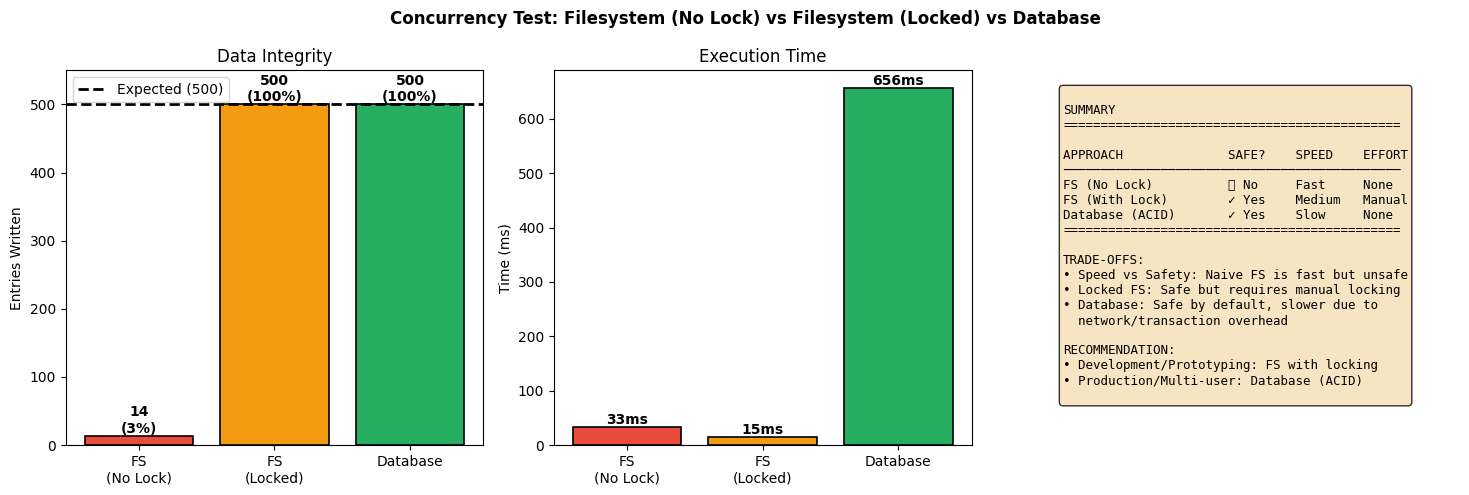


[OK] Saved: concurrency_test_results.png


In [71]:
# Visualization - Three Approaches
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Concurrency Test: Filesystem (No Lock) vs Filesystem (Locked) vs Database", fontsize=12, fontweight='bold')

FS_NOLOCK_COLOR = "#e74c3c"  # Red - unsafe
FS_LOCKED_COLOR = "#f39c12"  # Orange - safe but requires effort
DB_COLOR = "#27ae60"          # Green - safe by default

# Chart 1: Data Integrity Comparison
ax1 = axes[0]
approaches = ['FS\n(No Lock)', 'FS\n(Locked)', 'Database']
actual_values = [file_results['actual'], file_locked_results['actual'], db_results['actual']]
colors = [FS_NOLOCK_COLOR, FS_LOCKED_COLOR, DB_COLOR]

bars = ax1.bar(approaches, actual_values, color=colors, edgecolor='black', linewidth=1.2)
ax1.axhline(y=EXPECTED_TOTAL, color='black', linestyle='--', linewidth=2, label=f'Expected ({EXPECTED_TOTAL})')
ax1.set_ylabel('Entries Written')
ax1.set_title('Data Integrity')
ax1.set_ylim(0, EXPECTED_TOTAL * 1.1)
ax1.legend()

# Add value labels
for bar, val in zip(bars, actual_values):
    pct = val / EXPECTED_TOTAL * 100
    ax1.annotate(f'{val}\n({pct:.0f}%)', xy=(bar.get_x() + bar.get_width()/2, val),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 2: Time Comparison
ax2 = axes[1]
times = [file_results['elapsed_ms'], file_locked_results['elapsed_ms'], db_results['elapsed_ms']]
bars = ax2.bar(approaches, times, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Time (ms)')
ax2.set_title('Execution Time')

# Add value labels
for bar, val in zip(bars, times):
    ax2.annotate(f'{val:.0f}ms', xy=(bar.get_x() + bar.get_width()/2, val),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 3: Safety vs Speed Trade-off
ax3 = axes[2]
ax3.axis('off')

summary = f"""
SUMMARY
{'='*45}

APPROACH              SAFE?    SPEED    EFFORT
{'─'*45}
FS (No Lock)          ❌ No     Fast     None
FS (With Lock)        ✓ Yes    Medium   Manual
Database (ACID)       ✓ Yes    Slow     None
{'='*45}

TRADE-OFFS:
• Speed vs Safety: Naive FS is fast but unsafe
• Locked FS: Safe but requires manual locking
• Database: Safe by default, slower due to
  network/transaction overhead

RECOMMENDATION:
• Development/Prototyping: FS with locking
• Production/Multi-user: Database (ACID)
"""
ax3.text(0.05, 0.95, summary, transform=ax3.transAxes, fontsize=9,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig("concurrency_test_results.png", dpi=150, bbox_inches='tight')
plt.show()
print("\n[OK] Saved: concurrency_test_results.png")

## 4.5 Key Takeaways

### The Real Story: It's About Default Safety vs Explicit Implementation

| Approach | Safe? | Speed | Effort Required |
|----------|-------|-------|-----------------|
| **Filesystem (No Lock)** | ❌ No | Fast | None |
| **Filesystem (With Lock)** | ✓ Yes | Medium | Manual implementation |
| **Database (ACID)** | ✓ Yes | Slower | None - built-in |

> **Key Insight:** Filesystems are not inherently broken for concurrency - they just require **explicit locking**. Databases provide safety **by default** through ACID transactions.

### When to Use Each Approach

> **Filesystem WITHOUT Locking (FSAgent default)**
> - Single-user CLI tools
> - Development and quick prototyping
> - When you control all access to the files
> - ⚠️ Never use for multi-user or concurrent scenarios

> **Filesystem WITH Locking (`fcntl.flock()`)**
> - Multi-process scenarios on local filesystems
> - When you need human-readable files AND concurrency
> - Development teams with shared file access
> - ⚠️ Does NOT work reliably on NFS or network shares

> **Database (MemAgent with ACID)**
> - Production deployments
> - Multi-user applications
> - When data integrity is non-negotiable
> - Network/distributed scenarios
> - Background processes alongside user queries

### The ACID Guarantee

| Property | What It Means | Why It Matters for Agents |
|----------|---------------|---------------------------|
| **Atomicity** | All or nothing | Partial memory writes won't corrupt state |
| **Consistency** | Rules enforced | Can't store invalid data (e.g., missing thread_id) |
| **Isolation** | No interference | Concurrent users don't see each other's incomplete work |
| **Durability** | Survives crashes | Memory persists even if agent crashes mid-operation |

### Bottom Line

**For production agent deployments**, the database's ACID guarantees provide reliability without requiring you to implement locking correctly. The performance overhead is usually worth the peace of mind.

**For development/prototyping**, filesystem with proper locking (`fcntl.flock()`) can work well, but remember it won't work on all filesystem types (NFS, SMB network shares).